- To improve data quality for anomaly detection in time series data, we can focus on removing outliers due to sensor reading errors while preserving anomalies. Additionally, performing resampling or aggregation can help reduce noise and highlight higher-level patterns relevant for anomaly detection. Find common steps to improve data quality for this particular use and implement those. Evaluate the performance of the algorithms compare to the original notebook. 

### importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
#read csv file
df = pd.read_csv('../Data/sensor.csv').drop('Unnamed: 0', axis=1)

In [3]:
# dimention of dataframe
df.shape

(220320, 54)

In [154]:
#printing info about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-null       float64
 17  sensor_16 

In [155]:
# count the occurrences of each unique value in the machine_status column
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

## Handle missing values

In [156]:
# calculate the percentage of missing values for each column in the DataFrame.
percentage_missing = df.isnull().sum().sort_values(ascending=False)/len(df)*100
percentage_missing

sensor_15         100.000000
sensor_50          34.956881
sensor_51           6.982117
sensor_00           4.633261
sensor_07           2.474129
sensor_08           2.317992
sensor_06           2.177741
sensor_09           2.085603
sensor_01           0.167484
sensor_30           0.118464
sensor_29           0.032680
sensor_32           0.030864
sensor_18           0.020879
sensor_17           0.020879
sensor_22           0.018609
sensor_25           0.016340
sensor_16           0.014070
sensor_49           0.012255
sensor_48           0.012255
sensor_47           0.012255
sensor_46           0.012255
sensor_45           0.012255
sensor_44           0.012255
sensor_43           0.012255
sensor_42           0.012255
sensor_41           0.012255
sensor_40           0.012255
sensor_39           0.012255
sensor_38           0.012255
sensor_14           0.009532
sensor_26           0.009078
sensor_03           0.008624
sensor_10           0.008624
sensor_13           0.008624
sensor_12     

In [4]:
# drop low quality columns
df.drop(['sensor_15', 'sensor_50', 'machine_status'],inplace = True,axis=1)
# set timestamp to date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

In [176]:
# Get columns with missing values
columns_with_missing_values = df.columns[df.isnull().any()].tolist
columns_with_missing_values

<bound method IndexOpsMixin.tolist of Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_51'],
      dtype='object')>

In [5]:
# Get columns with missing values
columns_with_missing_values = df.columns[df.isnull().any()]

# Select columns to interpolate
columns_to_interpolate = columns_with_missing_values

# Interpolate missing values
df_interpolated = df[columns_to_interpolate].interpolate()

# Print the interpolated DataFrame
print(df_interpolated)

                     sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  \
timestamp                                                                     
2018-04-01 00:00:00   2.465394   47.09201  53.211800  46.310760  634.375000   
2018-04-01 00:01:00   2.465394   47.09201  53.211800  46.310760  634.375000   
2018-04-01 00:02:00   2.444734   47.35243  53.211800  46.397570  638.888900   
2018-04-01 00:03:00   2.460474   47.09201  53.168400  46.397568  628.125000   
2018-04-01 00:04:00   2.445718   47.13541  53.211800  46.397568  636.458300   
...                        ...        ...        ...        ...         ...   
2018-08-31 23:55:00   2.407350   47.69965  50.520830  43.142361  634.722229   
2018-08-31 23:56:00   2.400463   47.69965  50.564240  43.142361  630.902771   
2018-08-31 23:57:00   2.396528   47.69965  50.520830  43.142361  625.925903   
2018-08-31 23:58:00   2.406366   47.69965  50.520832  43.142361  635.648100   
2018-08-31 23:59:00   2.396528   47.69965  50.520832

## Check for redundant columns
Highly correlated features have a strong linear relationship and carry redundant information, leading to multicollinearity. Removing these variables is crucial in data preprocessing to improve model efficiency and accuracy, enhancing machine learning performance.https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python, https://towardsdatascience.com/anomaly-detection-in-time-series-sensor-data-86fd52e62538

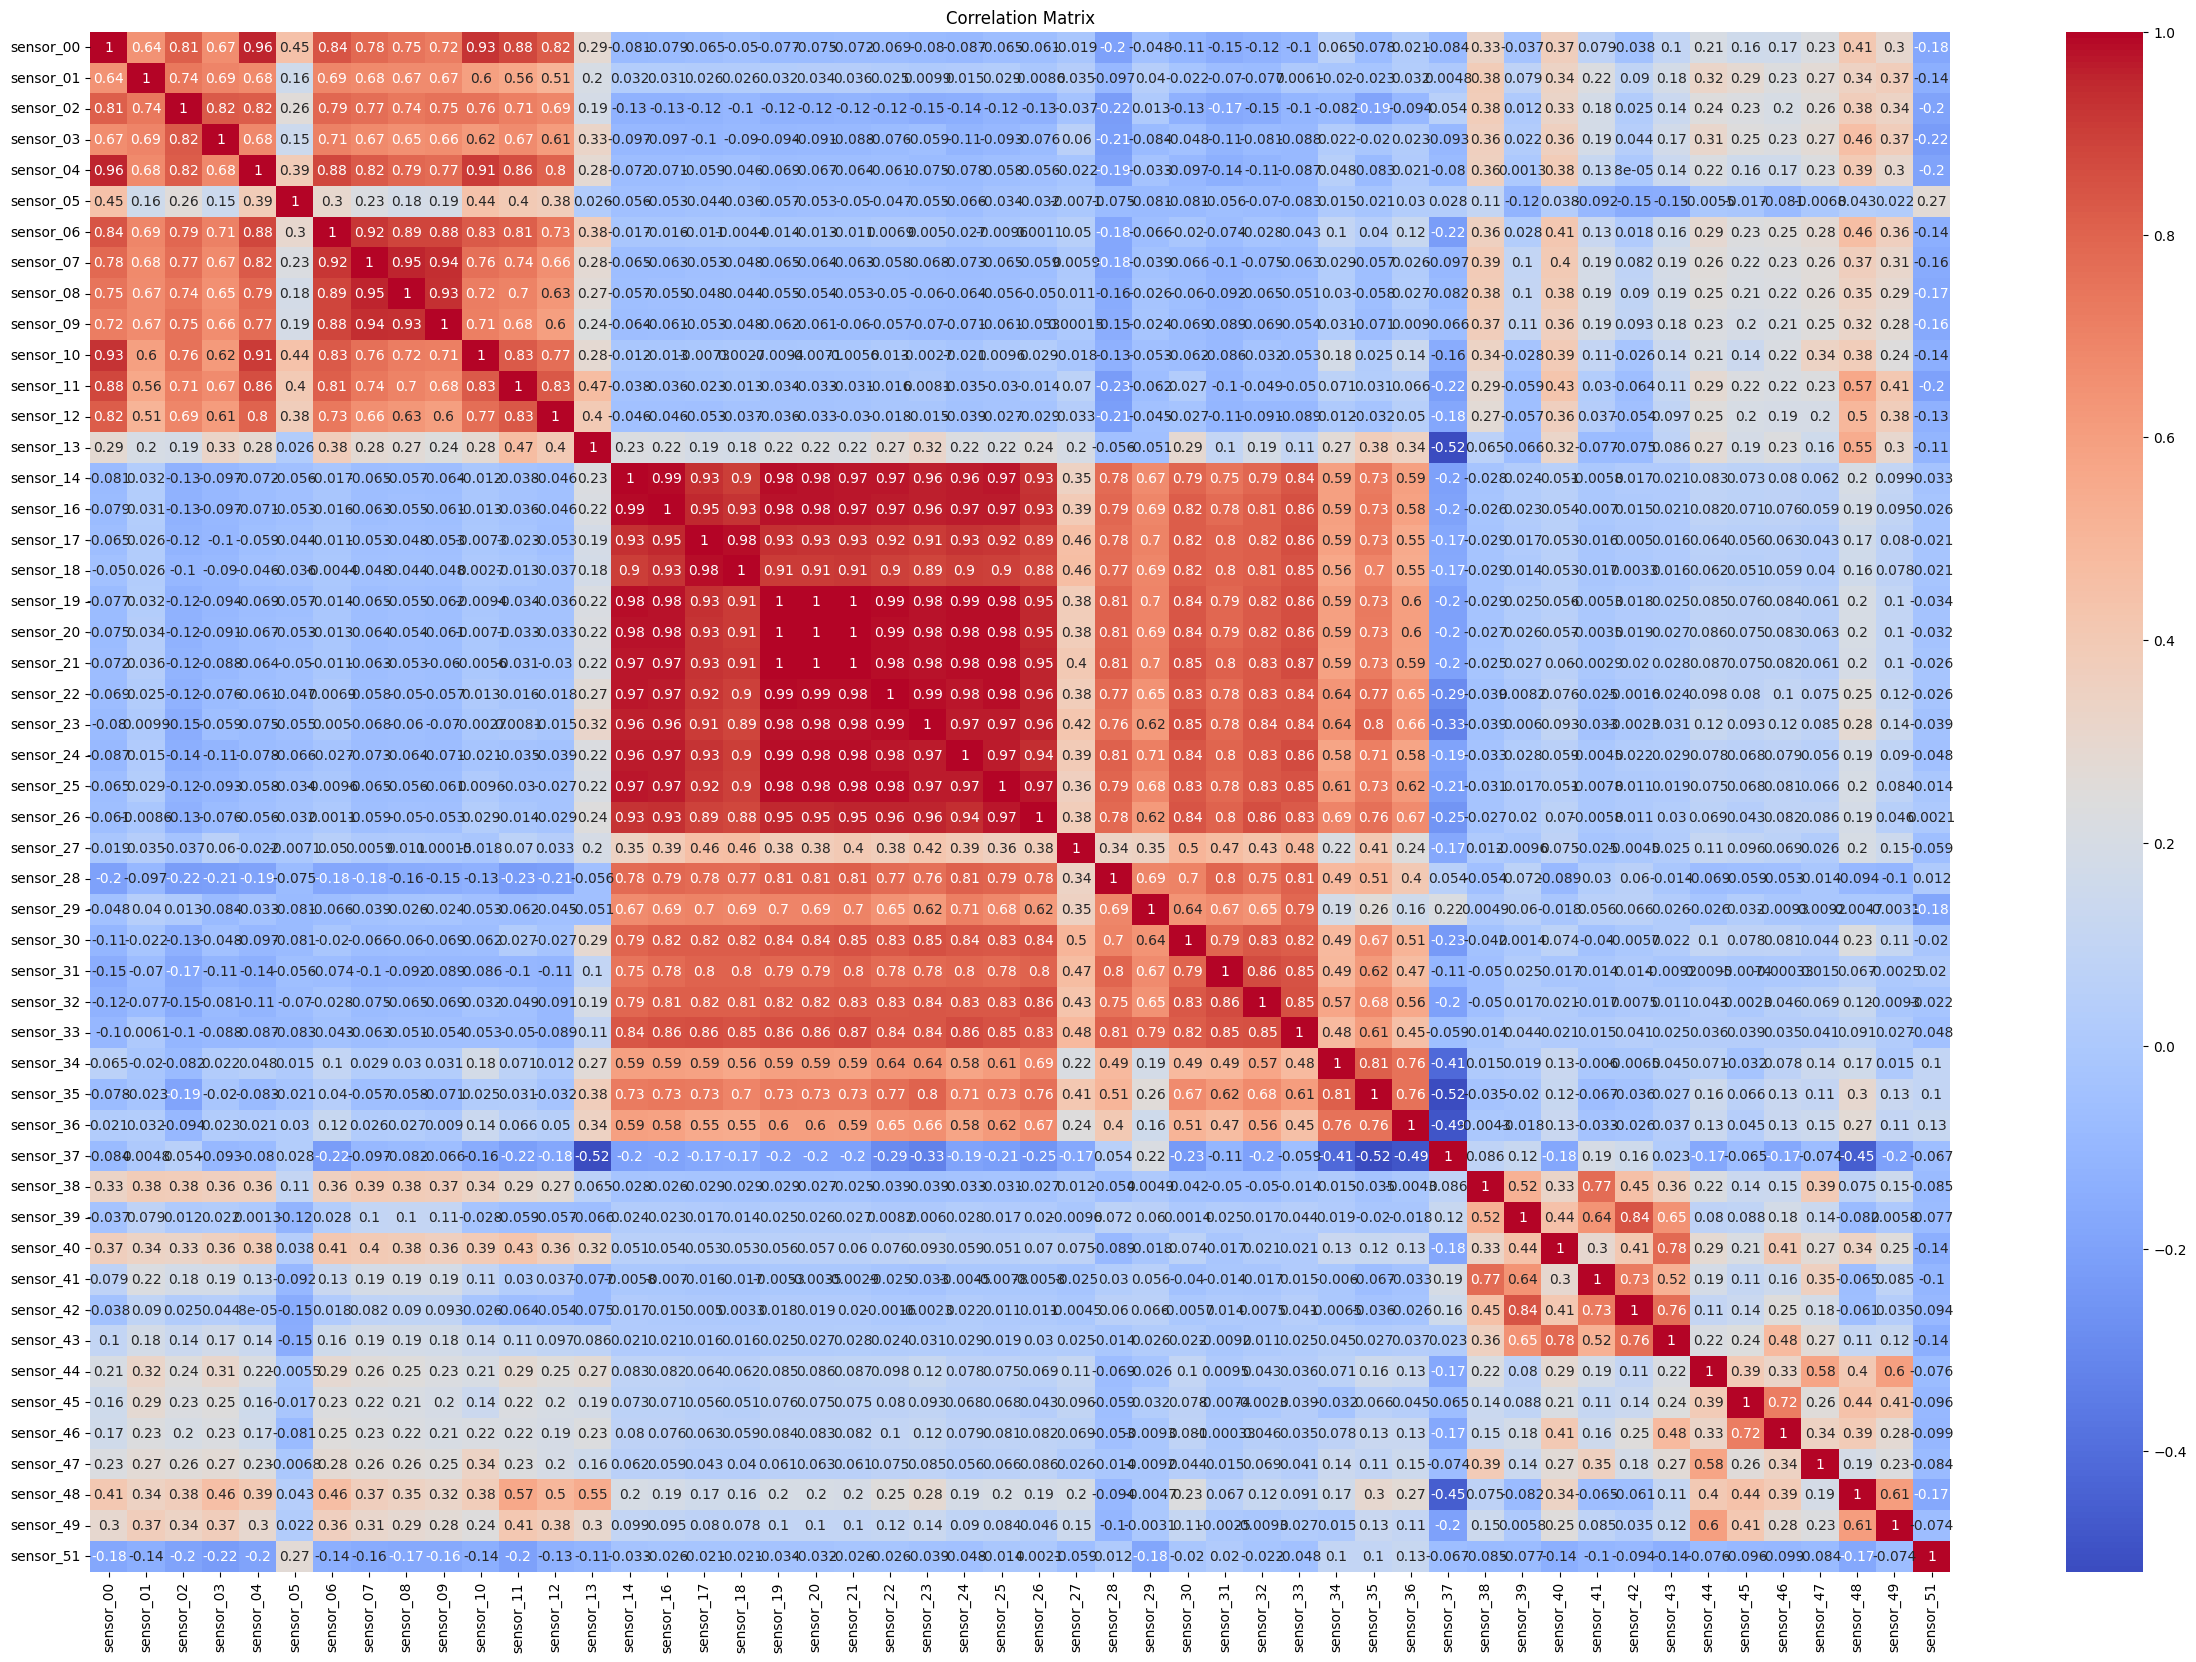

In [181]:
# Calculate the correlation matrix
correlation_matrix = df_interpolated.corr()

# Plot the correlation matrix
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [182]:
# Calculate correlation matrix
corr_matrix = correlation_matrix.abs()

# Create an upper triangular matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Select columns to drop
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

# Drop the columns from the dataframe
new_df = df_interpolated.drop(to_drop, axis=1)

# Print the columns to drop
print("Columns to drop:")
print(to_drop)

# Print the modified dataframe
print("\nModified dataframe:")
new_df.head()

Columns to drop:
['sensor_04', 'sensor_08', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

Modified dataframe:


sensor_00  sensor_01  sensor_02  sensor_03  sensor_05  \
timestamp                                                                    
2018-04-01 00:00:00   2.465394   47.09201    53.2118  46.310760   76.45975   
2018-04-01 00:01:00   2.465394   47.09201    53.2118  46.310760   76.45975   
2018-04-01 00:02:00   2.444734   47.35243    53.2118  46.397570   73.54598   
2018-04-01 00:03:00   2.460474   47.09201    53.1684  46.397568   76.98898   
2018-04-01 00:04:00   2.445718   47.13541    53.2118  46.397568   76.58897   

                     sensor_06  sensor_07  sensor_09  sensor_10  sensor_11  \
timestamp                                                                    
2018-04-01 00:00:00   13.41146   16.13136   15.05353   37.22740   47.52422   
2018-04-01 00:01:00   13.41146   16.13136   15.05353   37.22740   47.52422   
2018-04-01 00:02:00   13.32465   16.03733   15.01013   37.86777   48.17723   
2018-04-01 00:03:00   13.31742   16.24711   15.08247   38.57977   48.65607   
2018-04-01 00:04:00   13.35359   16.21094   15.08247   39.48939   49.06298   

                     ...  sensor_41  sensor_42  sensor_43  sensor_44  \
timestamp            ...                                               
2018-04-01 00:00:00  ...   30.98958  31.770832   41.92708  39.641200   
2018-04-01 00:01:00  ...   30.98958  31.770832   41.92708  39.641200   
2018-04-01 00:02:00  ...   30.46875  31.770830   41.66666  39.351852   
2018-04-01 00:03:00  ...   30.46875  31.510420   40.88541  39.062500   
2018-04-01 00:04:00  ...   30.98958  31.510420   41.40625  38.773150   

                     sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
timestamp                                                                    
2018-04-01 00:00:00   65.68287   50.92593  38.194440   157.9861   67.70834   
2018-04-01 00:01:00   65.68287   50.92593  38.194440   157.9861   67.70834   
2018-04-01 00:02:00   65.39352   51.21528  38.194443   155.9606   67.12963   
2018-04-01 00:03:00   64.81481   51.21528  38.194440   155.9606   66.84028   
2018-04-01 00:04:00   65.10416   51.79398  38.773150   158.2755   66.55093   

                     sensor_51  
timestamp                       
2018-04-01 00:00:00   201.3889  
2018-04-01 00:01:00   201.3889  
2018-04-01 00:02:00   203.7037  
2018-04-01 00:03:00   203.1250  
2018-04-01 00:04:00   201.3889  

[5 rows x 37 columns]

In [183]:
start_date = new_df.index.min()
end_date = new_df.index.max()

print("Start Date:", start_date)
print("End Date:", end_date)

Start Date: 2018-04-01 00:00:00
End Date: 2018-08-31 23:59:00


## Stationarity and Autocorrelation
Stationarity refers to a time series process whose statistical properties, such as mean, variance, and covariance, remain constant over time. In simpler terms, it means that the data does not exhibit trends or seasonality and has a consistent behavior.


To check for stationarity in a time series, we can visually inspect plots, analyze summary statistics, perform statistical tests like ADF and KPSS, and examine rolling statistics for significant variations.

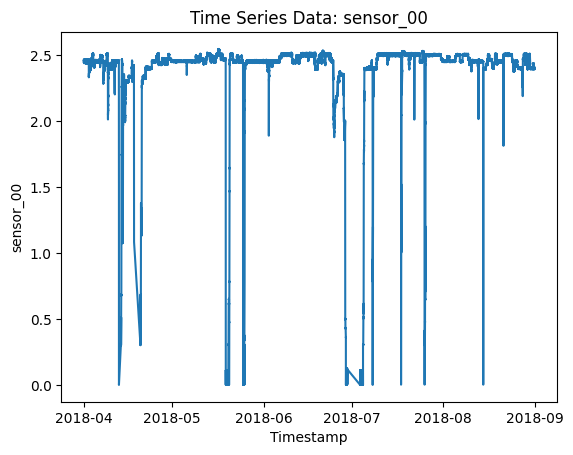

Partition 1: Mean=2.3055190551900053, Variance=0.27133808516979074
Partition 2: Mean=2.243782430699331, Variance=0.45274384544404567
ADF Test p-value for sensor_00: 6.818597470912154e-08



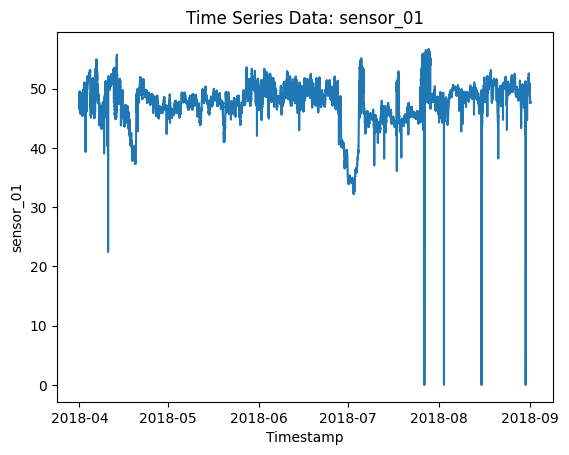

Partition 1: Mean=47.882336006536704, Variance=5.580551726514818
Partition 2: Mean=47.31211493413775, Variance=16.05938539927896
ADF Test p-value for sensor_01: 1.1849193350507027e-07



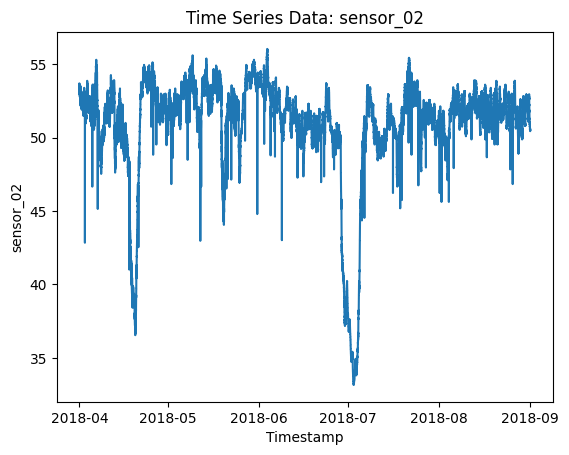

Partition 1: Mean=51.60907027571999, Variance=8.220140017065466
Partition 2: Mean=50.12511368315081, Variance=17.577297951198904
ADF Test p-value for sensor_02: 0.0009438067461282447



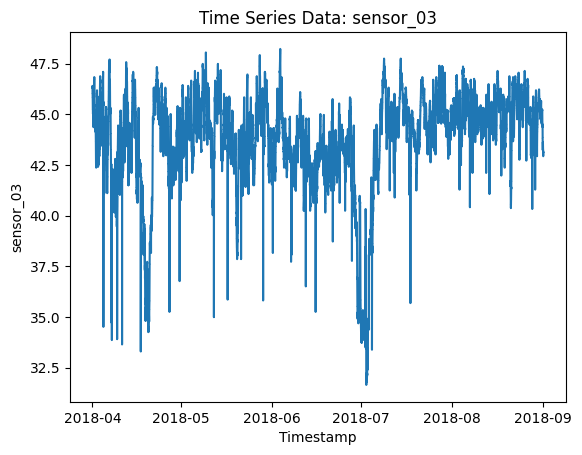

Partition 1: Mean=43.58345071105233, Variance=4.5150616639220065
Partition 2: Mean=43.92122290705507, Variance=7.130863926859445
ADF Test p-value for sensor_03: 7.305190335567641e-11



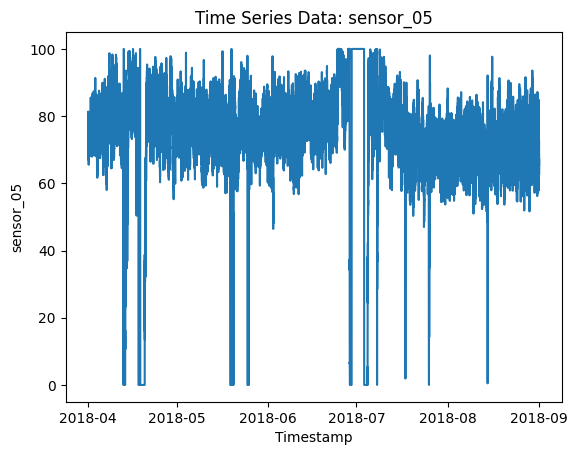

Partition 1: Mean=72.85015998031463, Variance=348.93325875716226
Partition 2: Mean=73.93972128581183, Variance=249.12901175632052
ADF Test p-value for sensor_05: 9.426813484912213e-23



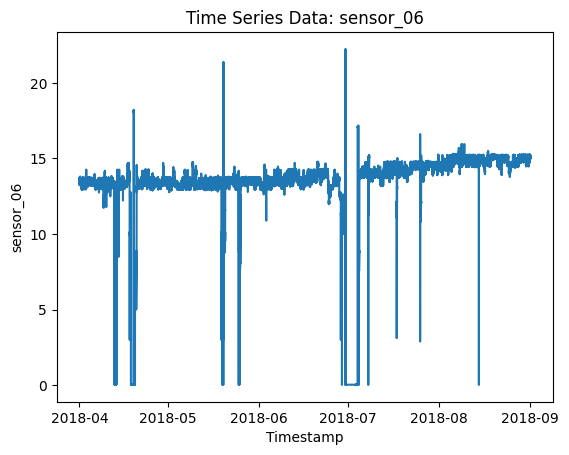

Partition 1: Mean=12.937609415376059, Variance=5.0145362422681625
Partition 2: Mean=13.481050525366733, Variance=11.69384795953775
ADF Test p-value for sensor_06: 8.701543174825598e-11



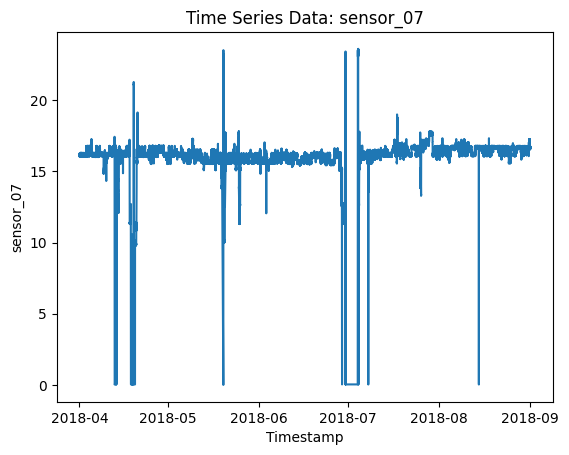

Partition 1: Mean=15.553181892052564, Variance=6.293438602881888
Partition 2: Mean=15.398336414117205, Variance=14.176100106315095
ADF Test p-value for sensor_07: 1.2234559595656523e-15



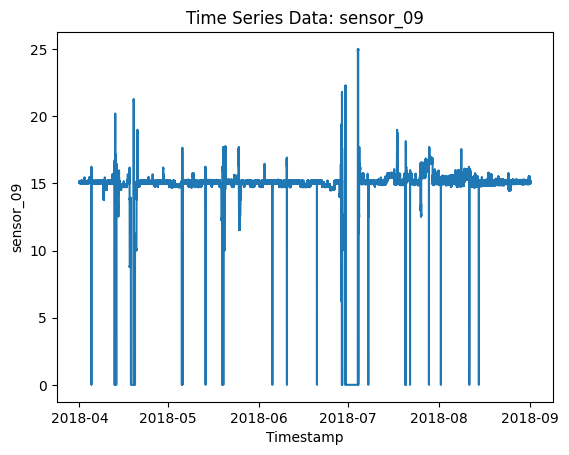

Partition 1: Mean=14.657048298313882, Variance=4.877676580306004
Partition 2: Mean=14.326582193023473, Variance=12.545399579756621
ADF Test p-value for sensor_09: 1.2617760222377592e-13



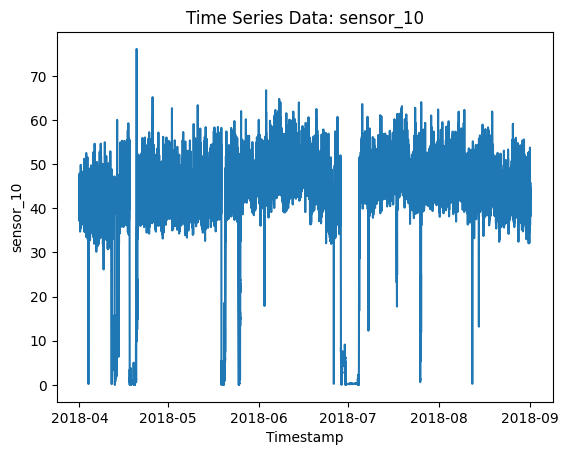

Partition 1: Mean=41.05334832728983, Variance=126.78313051864674
Partition 2: Mean=41.885928600751306, Variance=165.43158919760882
ADF Test p-value for sensor_10: 4.689963561469033e-13



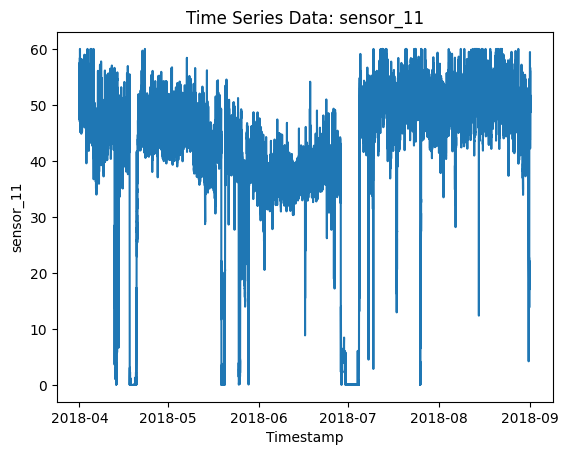

Partition 1: Mean=39.962065623289895, Variance=132.07820248343884
Partition 2: Mean=43.873538339230606, Variance=201.270291937177
ADF Test p-value for sensor_11: 4.300838390993114e-11



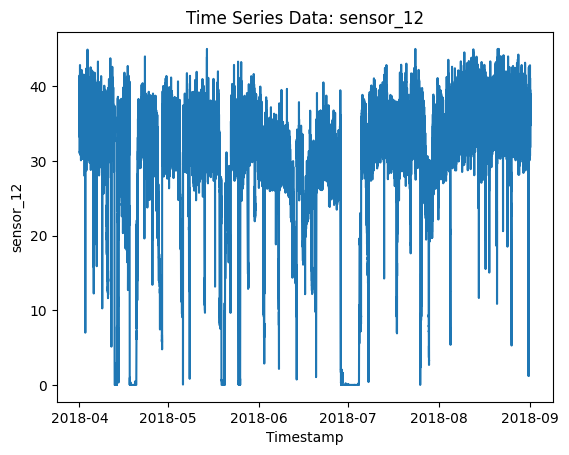

Partition 1: Mean=28.452280209379644, Variance=92.74647499305506
Partition 2: Mean=29.820059330264385, Variance=110.92958928137575
ADF Test p-value for sensor_12: 5.826050994175245e-16



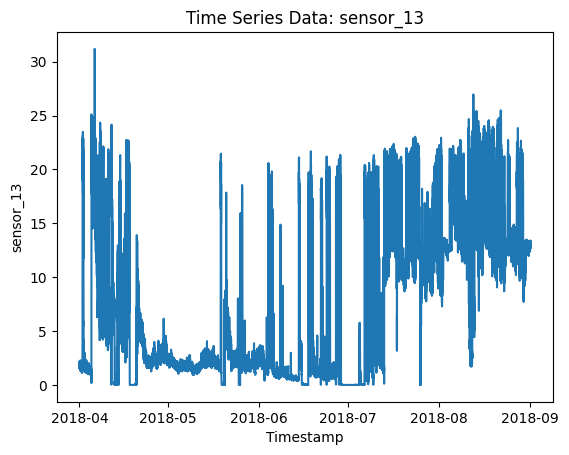

Partition 1: Mean=3.366612147826417, Variance=16.740799984366546
Partition 2: Mean=10.79055038981016, Variance=50.96700159036698
ADF Test p-value for sensor_13: 6.012847814767559e-16



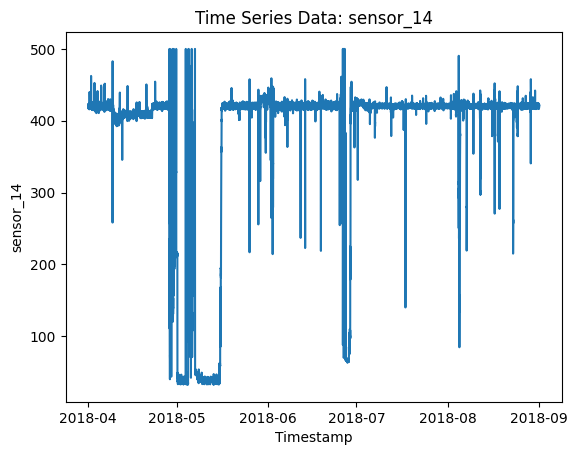

Partition 1: Mean=344.3289115639897, Variance=20345.317493090617
Partition 2: Mean=409.37650832037525, Variance=3174.803331958543
ADF Test p-value for sensor_14: 0.00012924257795320987



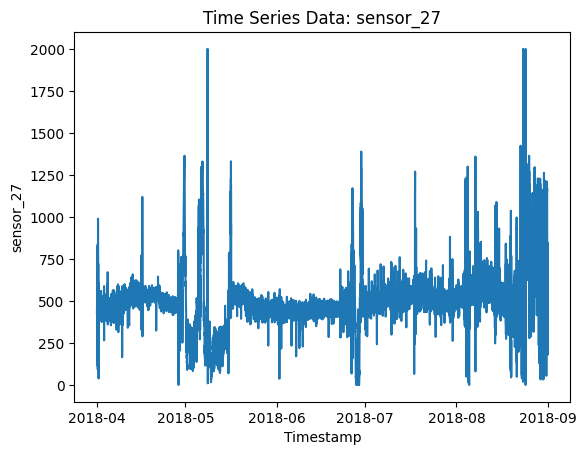

Partition 1: Mean=466.84088378269354, Variance=28466.953439274508
Partition 2: Mean=536.167883604034, Variance=26806.205648237094
ADF Test p-value for sensor_27: 8.015227883956328e-26



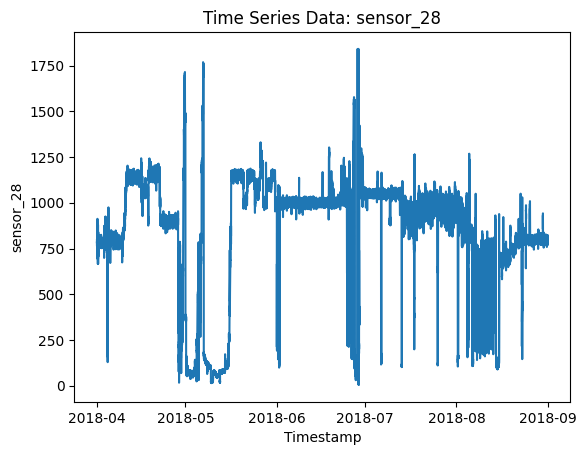

Partition 1: Mean=835.0807016570417, Variance=145563.5724174605
Partition 2: Mean=868.3009692038717, Variance=49913.83026986861
ADF Test p-value for sensor_28: 2.202667998468129e-12



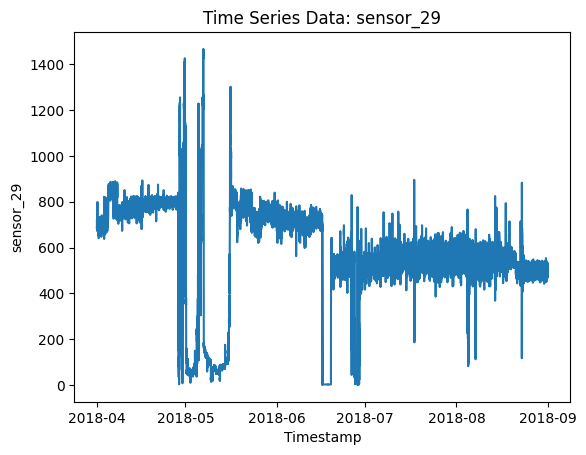

Partition 1: Mean=647.2146403743106, Variance=74407.32535804542
Partition 2: Mean=504.961656409344, Variance=17491.521770856278
ADF Test p-value for sensor_29: 6.67833439180061e-08



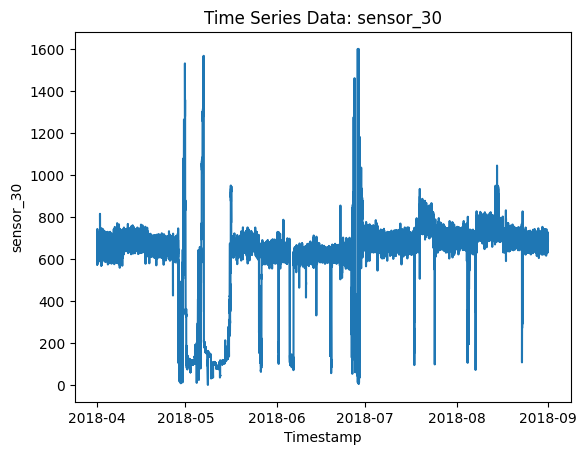

Partition 1: Mean=547.6379161273161, Variance=55429.99822648586
Partition 2: Mean=680.3110825066991, Variance=12998.008165600904
ADF Test p-value for sensor_30: 6.559590568953907e-12



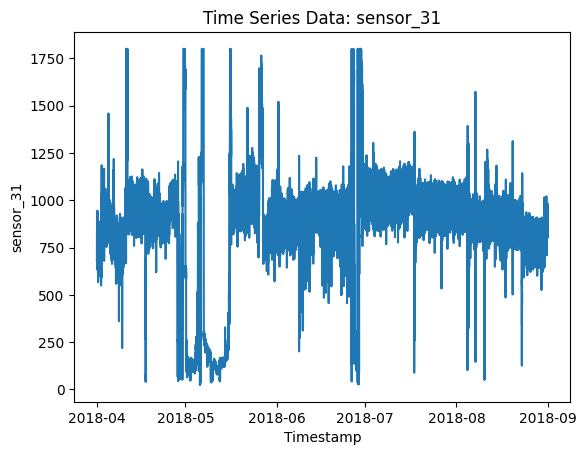

Partition 1: Mean=804.7216460441701, Variance=125151.23754895662
Partition 2: Mean=921.9288416369368, Variance=28773.60168466168
ADF Test p-value for sensor_31: 2.7545391714828444e-13



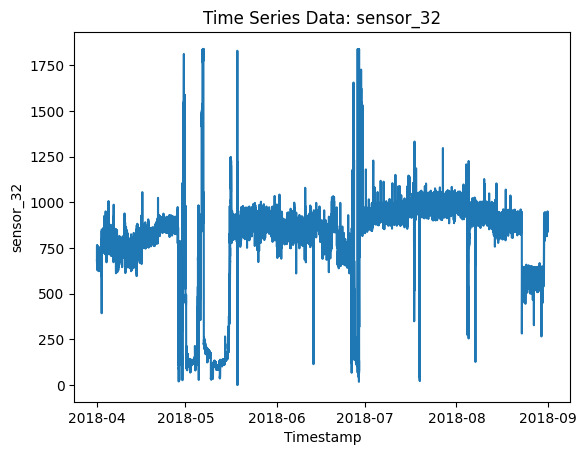

Partition 1: Mean=723.9259104150008, Variance=88039.80528889278
Partition 2: Mean=884.4742488723488, Variance=34985.33570271213
ADF Test p-value for sensor_32: 3.484908364214771e-08



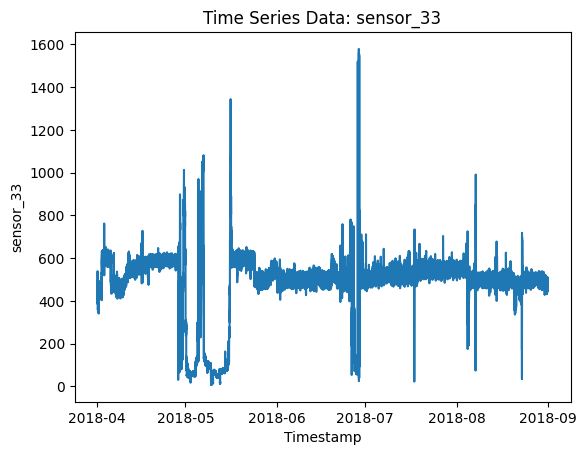

Partition 1: Mean=464.7652880125906, Variance=38298.60126921799
Partition 2: Mean=508.04893386101594, Variance=6217.299275176075
ADF Test p-value for sensor_33: 9.38752887715692e-11



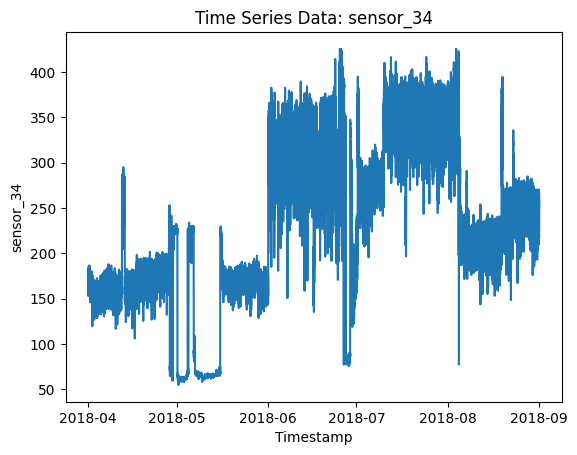

Partition 1: Mean=185.6111609285548, Variance=6349.2461154645725
Partition 2: Mean=284.3316966268855, Variance=4398.94053297556
ADF Test p-value for sensor_34: 1.4174519083826459e-06



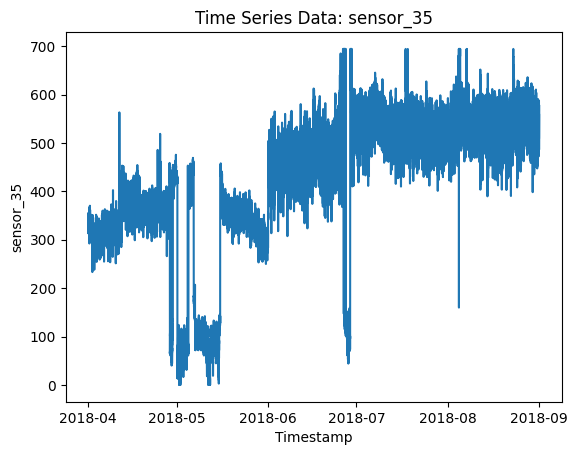

Partition 1: Mean=330.549330488054, Variance=15906.079316517236
Partition 2: Mean=523.7042055423648, Variance=5638.483722005845
ADF Test p-value for sensor_35: 6.46073123922234e-08



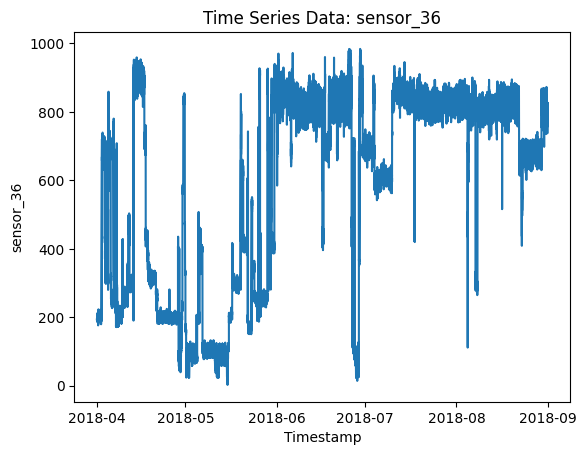

Partition 1: Mean=423.32268142379263, Variance=88873.87187502404
Partition 2: Mean=762.7214411049997, Variance=21025.852430862058
ADF Test p-value for sensor_36: 3.847878800514415e-06



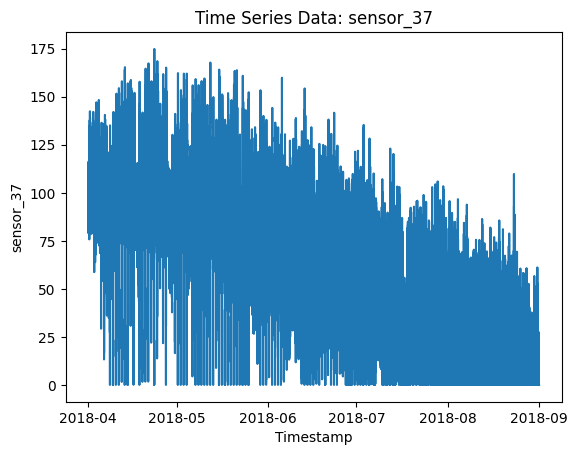

Partition 1: Mean=88.03976154988295, Variance=629.2871238405426
Partition 2: Mean=33.53656996857574, Variance=713.5135550715405
ADF Test p-value for sensor_37: 2.401058298437174e-22



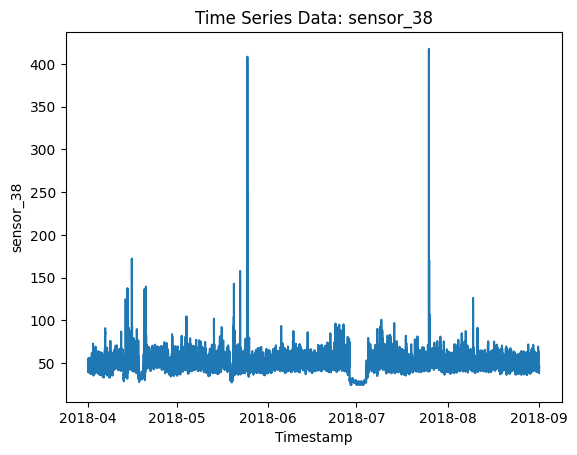

Partition 1: Mean=50.134366950353346, Variance=124.40683389447366
Partition 2: Mean=49.17607839354445, Variance=97.32930423483408
ADF Test p-value for sensor_38: 0.0



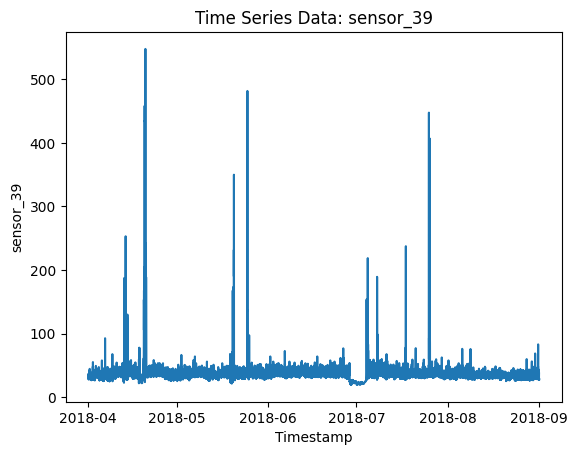

Partition 1: Mean=37.74977170621984, Variance=362.56402747187144
Partition 2: Mean=35.47047868422563, Variance=122.36377235887541
ADF Test p-value for sensor_39: 0.0



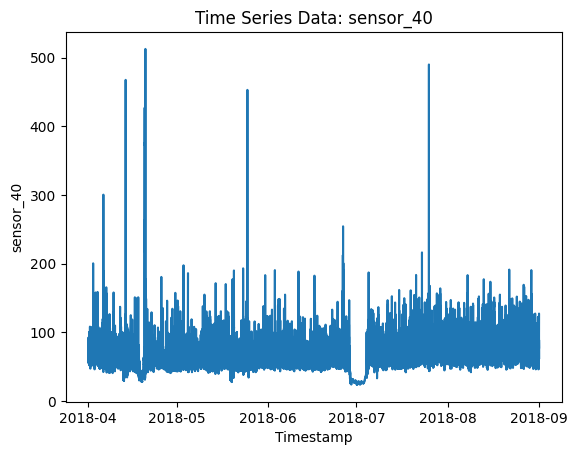

Partition 1: Mean=65.1103164239439, Variance=413.7295474179393
Partition 2: Mean=72.57689822130014, Variance=471.81211290744403
ADF Test p-value for sensor_40: 0.0



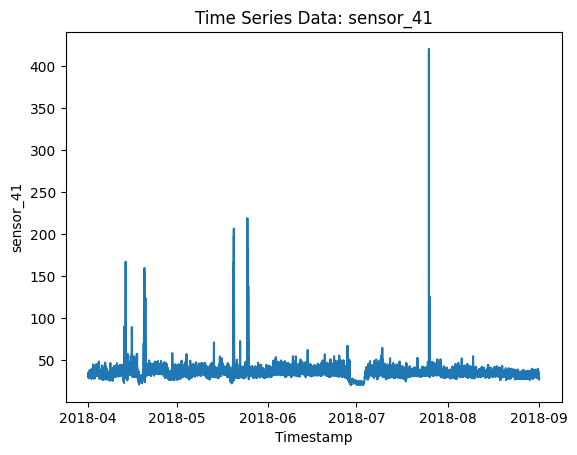

Partition 1: Mean=36.43868417425351, Variance=84.70735447472161
Partition 2: Mean=34.29076176579672, Variance=37.75410198648445
ADF Test p-value for sensor_41: 0.0



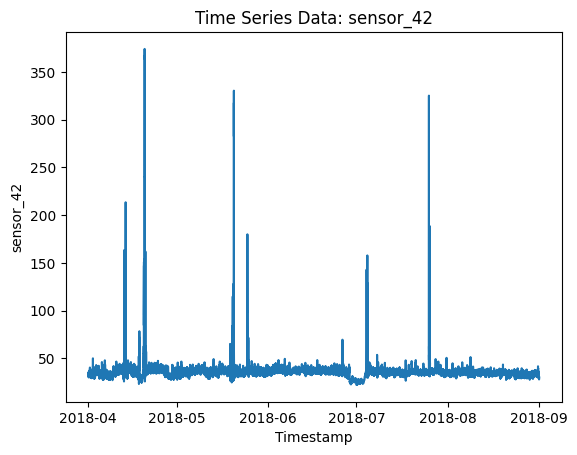

Partition 1: Mean=36.48380218293127, Variance=175.4971165956056
Partition 2: Mean=34.422443277148126, Variance=32.8717691021565
ADF Test p-value for sensor_42: 0.0



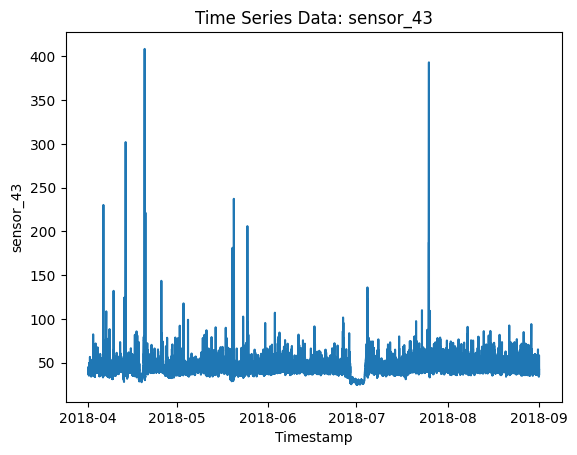

Partition 1: Mean=43.75730114379958, Variance=173.85015202464677
Partition 2: Mean=44.00118013757827, Variance=70.05826938939065
ADF Test p-value for sensor_43: 0.0



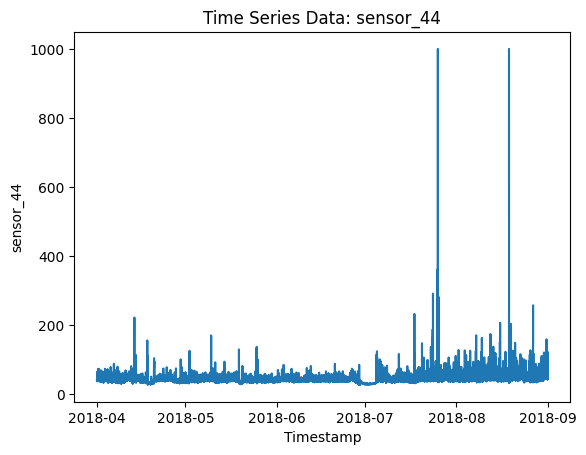

Partition 1: Mean=40.406120138584086, Variance=51.90916900598735
Partition 2: Mean=44.9067300466557, Variance=205.96593963223742
ADF Test p-value for sensor_44: 0.0



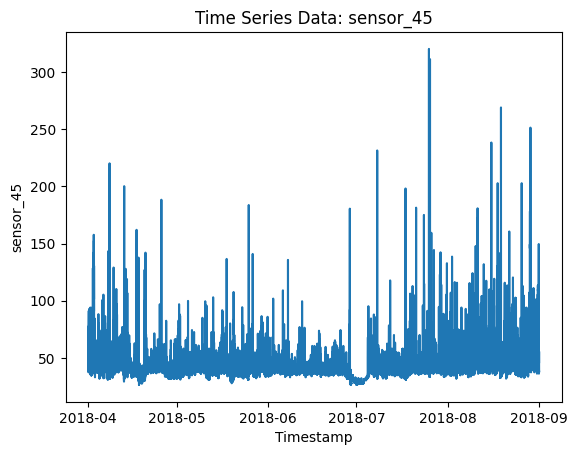

Partition 1: Mean=42.174437740163135, Variance=110.29914566817253
Partition 2: Mean=44.01414601594986, Variance=217.58487349033533
ADF Test p-value for sensor_45: 0.0



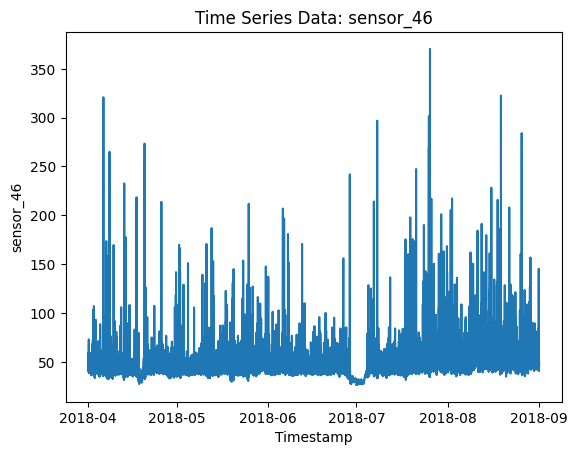

Partition 1: Mean=45.416452536246176, Variance=179.8968635792727
Partition 2: Mean=50.61948031089398, Variance=295.8248308562736
ADF Test p-value for sensor_46: 0.0



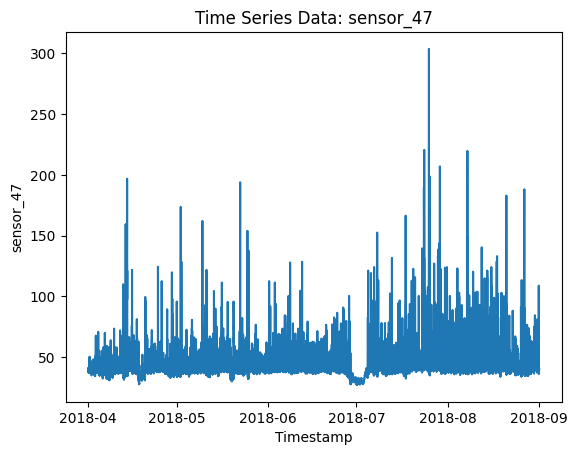

Partition 1: Mean=43.12341894716335, Variance=67.7148777298436
Partition 2: Mean=45.55725905924262, Variance=147.39486924471618
ADF Test p-value for sensor_47: 0.0



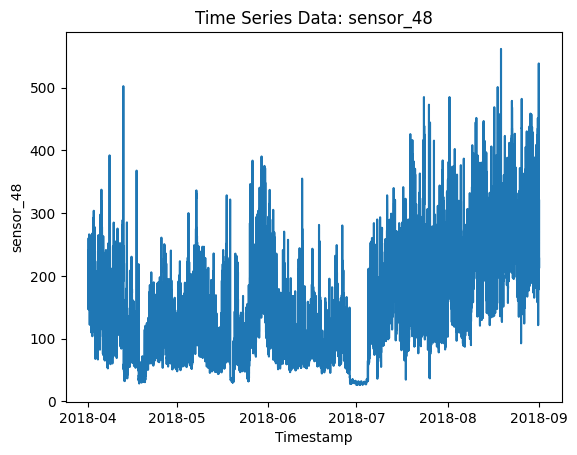

Partition 1: Mean=118.71558434429649, Variance=3388.6081105235544
Partition 2: Mean=183.0579414707756, Variance=8069.472917333984
ADF Test p-value for sensor_48: 3.214537097153328e-23



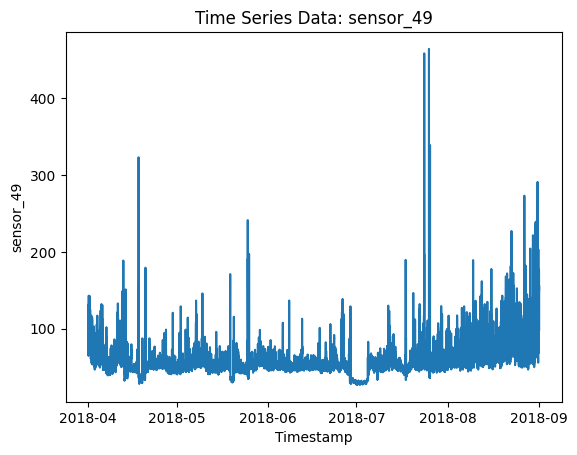

Partition 1: Mean=54.01154398932372, Variance=186.0633045269379
Partition 2: Mean=60.227943895749775, Variance=527.5663270642991
ADF Test p-value for sensor_49: 0.0



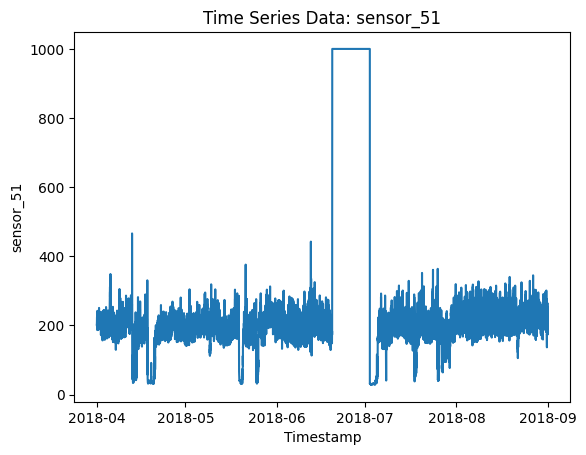

Partition 1: Mean=188.3063530072964, Variance=2375.763477507143
Partition 2: Mean=328.22821678241843, Variance=92617.19844435265


In [184]:

from statsmodels.tsa.stattools import adfuller

# Iterate over the sensor data columns
for column in new_df.columns:
    # Visual inspection
    plt.plot(new_df.index, new_df[column])
    plt.xlabel('Timestamp')
    plt.ylabel(column)
    plt.title(f'Time Series Data: {column}')
    plt.show()

   

    # Summary statistics
    partition1 = new_df[column][:len(new_df) // 2]
    partition2 = new_df[column][len(new_df) // 2:]
    mean1, mean2 = partition1.mean(), partition2.mean()
    var1, var2 = partition1.var(), partition2.var()
    print(f"Partition 1: Mean={mean1}, Variance={var1}")
    print(f"Partition 2: Mean={mean2}, Variance={var2}")

    # Statistical test (ADF test)
    result = adfuller(new_df[column])
    p_value = result[1]
    print(f"ADF Test p-value for {column}: {p_value}\n")

In [162]:
for column in new_df.columns:
    column_mean = new_df[column].mean()
    column_variance = new_df[column].var()
    print(f"{column}: Mean={column_mean}, Variance={column_variance}")
    

sensor_00: Mean=2.3722208156081623, Variance=0.16993139007945876
sensor_01: Mean=47.59161070051828, Variance=10.868003934588213
sensor_02: Mean=50.86739214871566, Variance=13.445571644799466
sensor_03: Mean=43.752481029367594, Variance=5.851012257580168
sensor_04: Mean=590.6739358978197, Variance=20742.88719299333
sensor_05: Mean=73.39641389272629, Variance=299.2293501283203
sensor_06: Mean=13.501537443828683, Variance=4.681754316713392
sensor_07: Mean=15.843151868847537, Variance=4.845084529500303
sensor_08: Mean=15.200721267392854, Variance=4.150959942790299
sensor_09: Mean=14.799209606885523, Variance=4.3763111321378965
sensor_10: Mean=41.4703390156575, Variance=146.25319484333843
sensor_11: Mean=41.91831905986677, Variance=170.47024004845412
sensor_12: Mean=29.13697472318412, Variance=102.29168230643272
sensor_13: Mean=7.078857517628702, Variance=47.634217522469214
sensor_14: Mean=376.8600409188042, Variance=12815.684826946419
sensor_27: Mean=501.5065890461449, Variance=28839.90999

## Dimention reduction (pca)
address the computational expense and inefficiency of training models use the most important features.

In [6]:
# sacle 
sc = StandardScaler()
scaled_features = sc.fit(df_interpolated).transform(df_interpolated)

In [7]:
def perform_dimentional_reduction(data, n_pca_components=50):
     
    """
    Perform PCA dimension reduction on the input data.

    Args:
        data: The input data to perform dimension reduction on.
        n_pca_components: The number of components to keep in the PCA step.
            Defaults to 50 if not provided.

    Returns:
        A tuple of PCA and t-SNE results: (pca_result).
    """


    # Perform PCA for dimension reduction
    pca = PCA(n_components=n_pca_components)
    pca_result = pca.fit_transform(data)

    return pca_result

In [8]:
# call  function perform_clustering_clusterin
pca_result= perform_dimentional_reduction(scaled_features)

C:\Users\Hallo\AppData\Local\Temp\ipykernel_20636\3136991786.py:24: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['machine_status'], dtype='object')
  ma = df.rolling(window_size).mean()


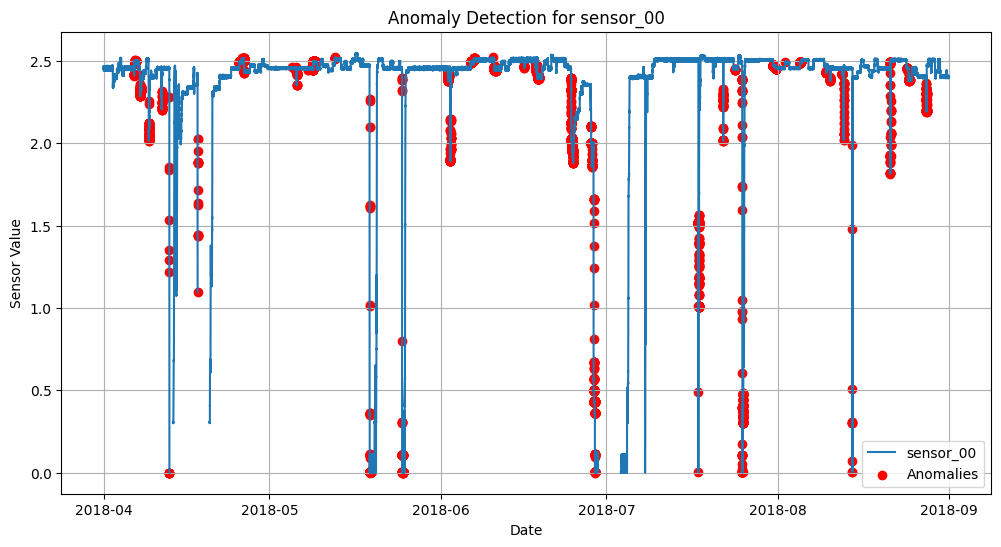

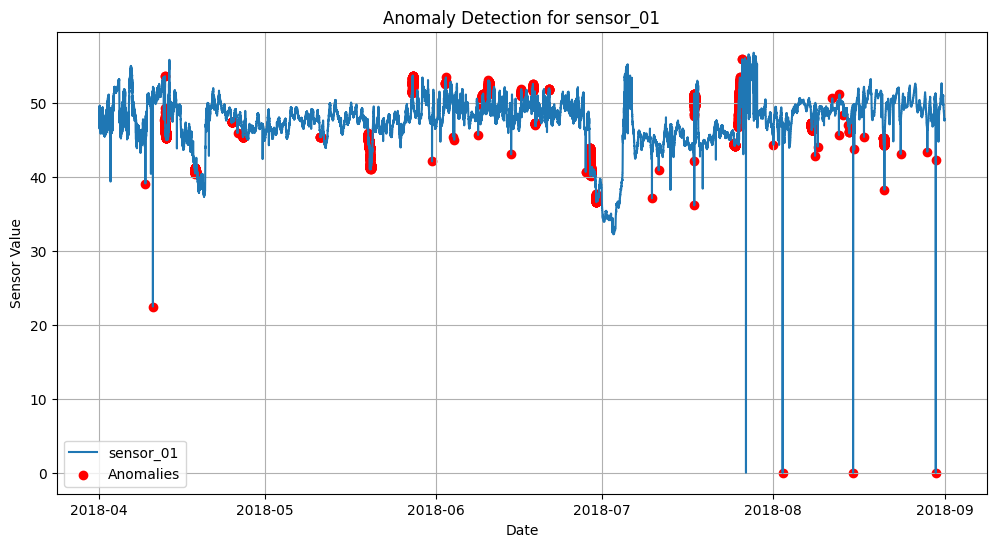

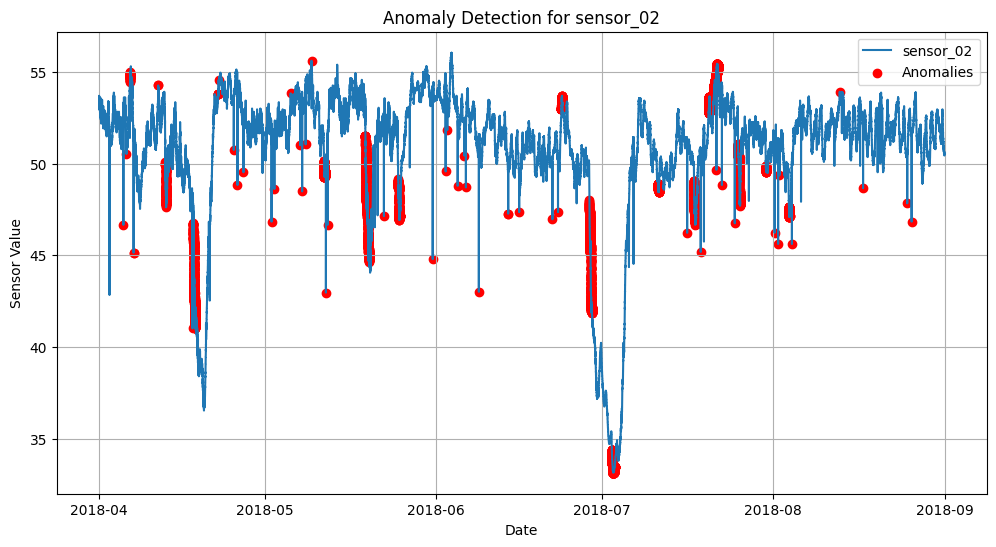

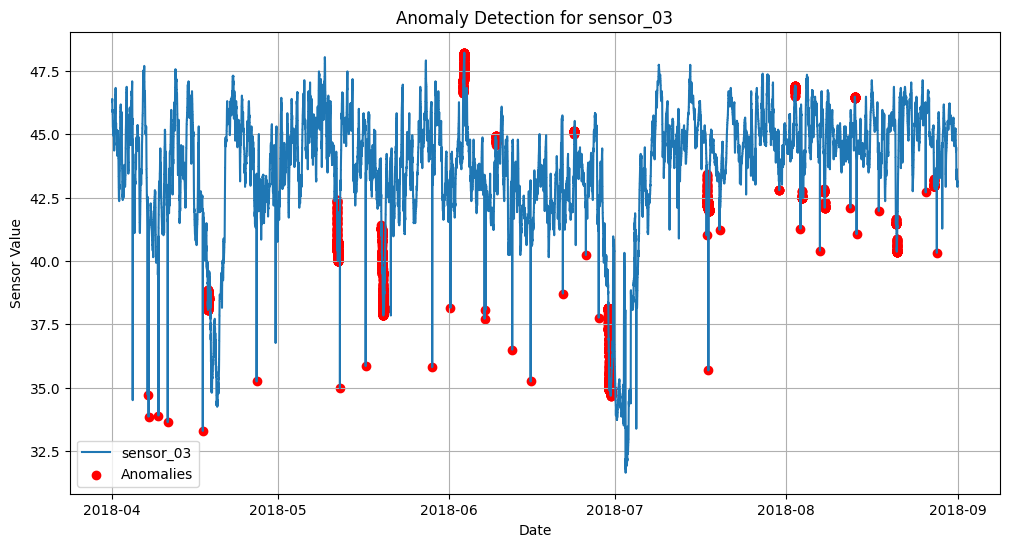

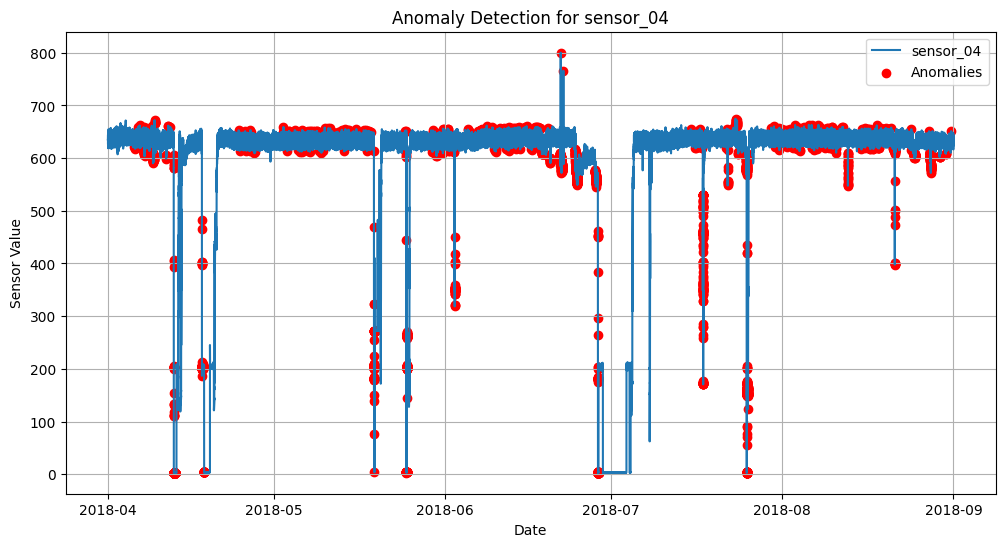

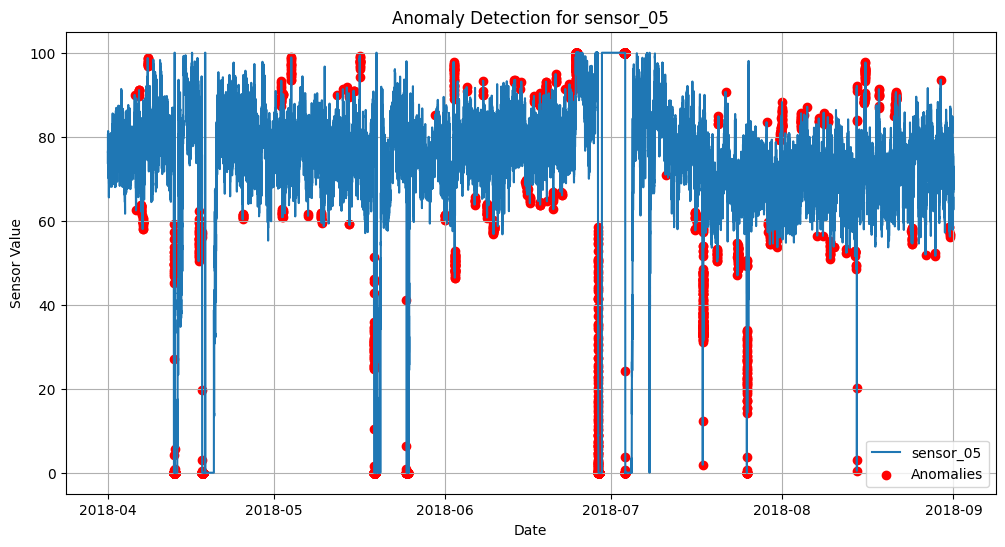

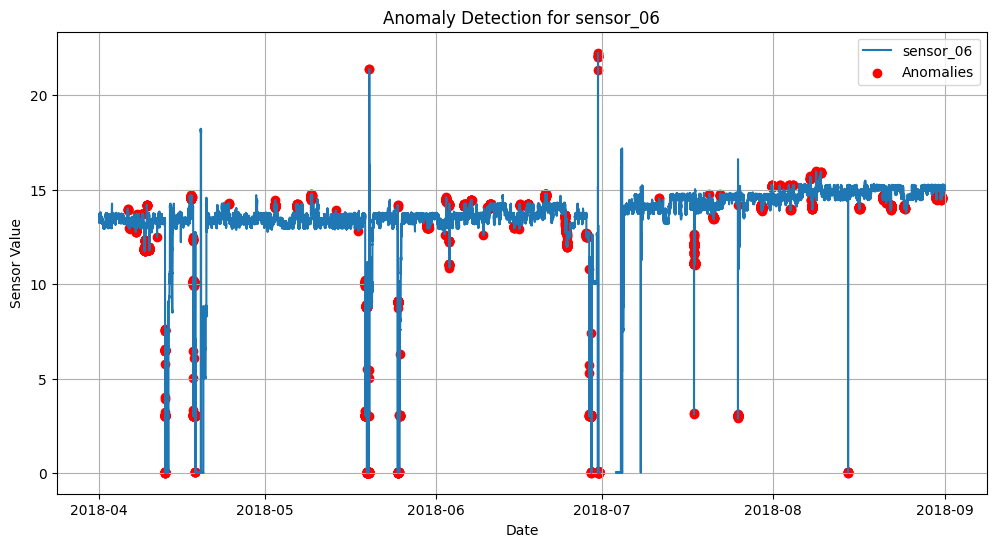

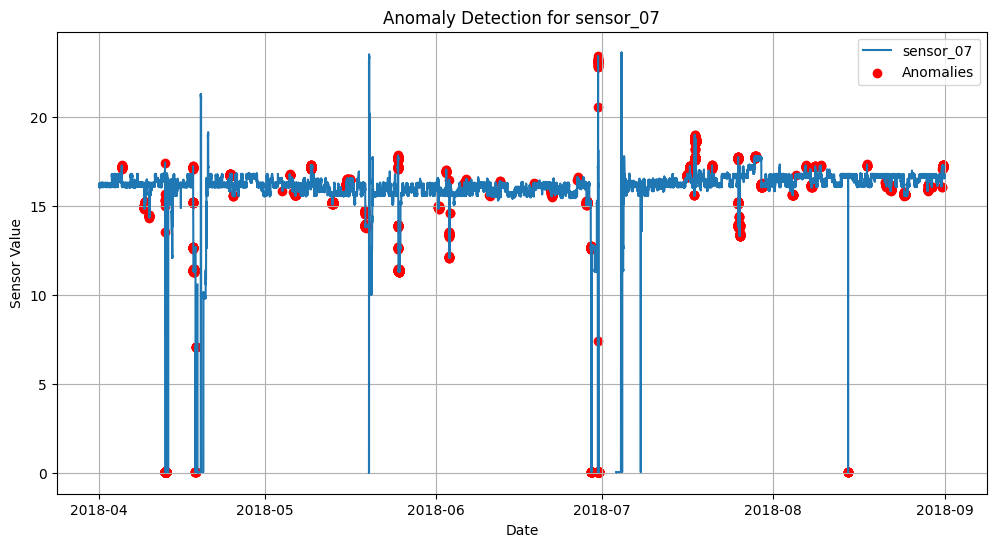

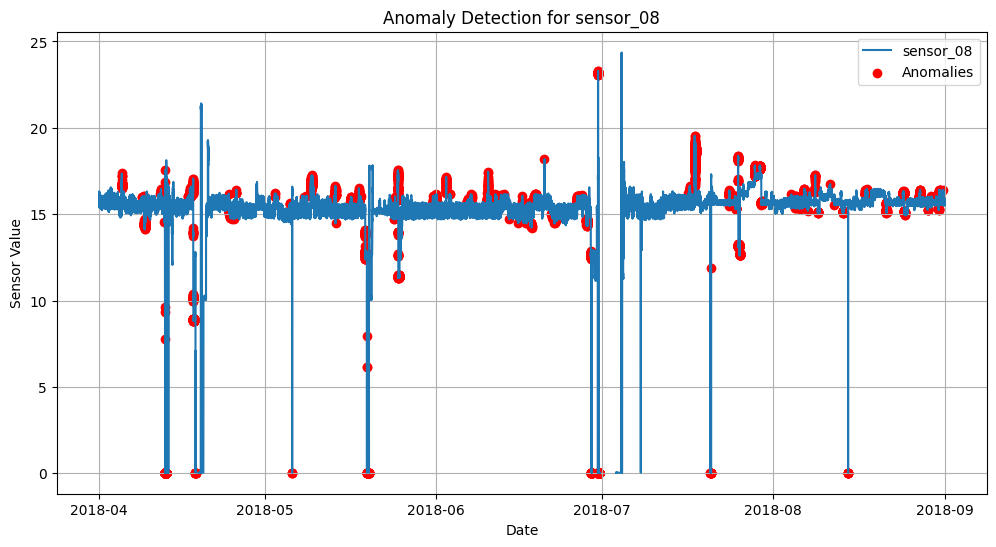

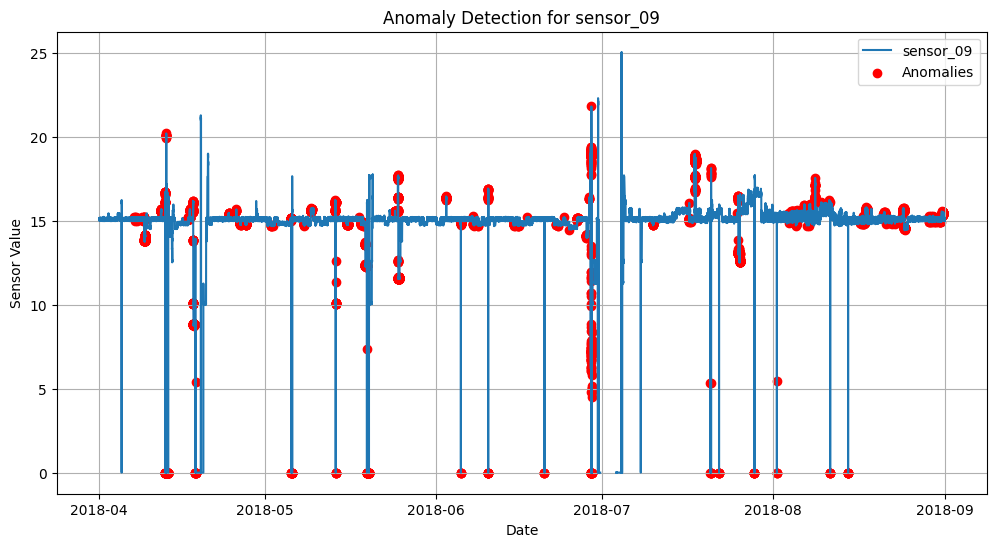

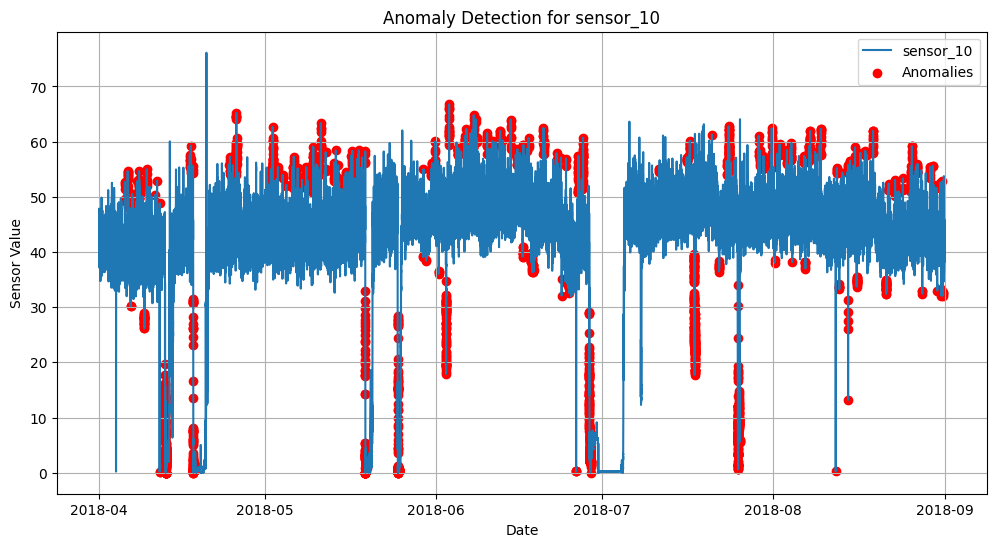

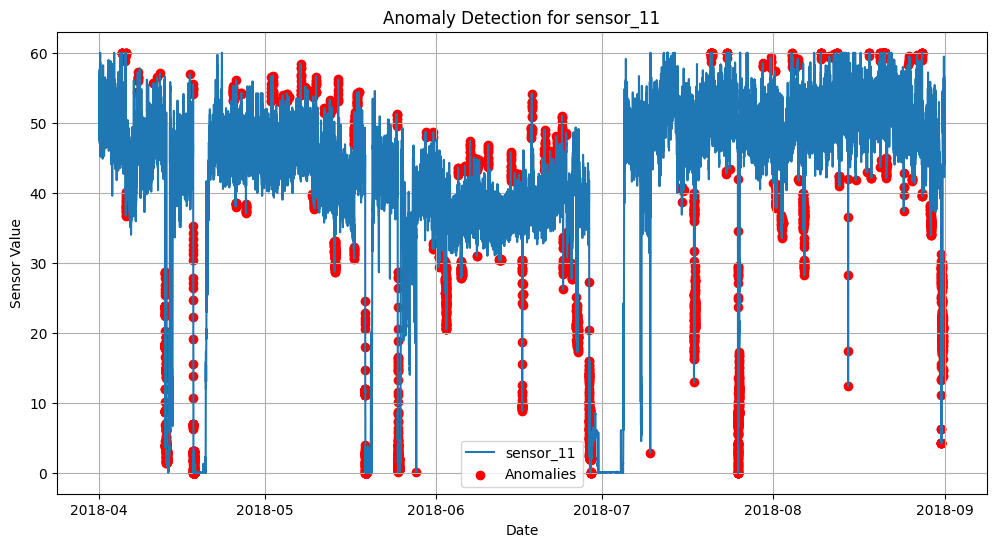

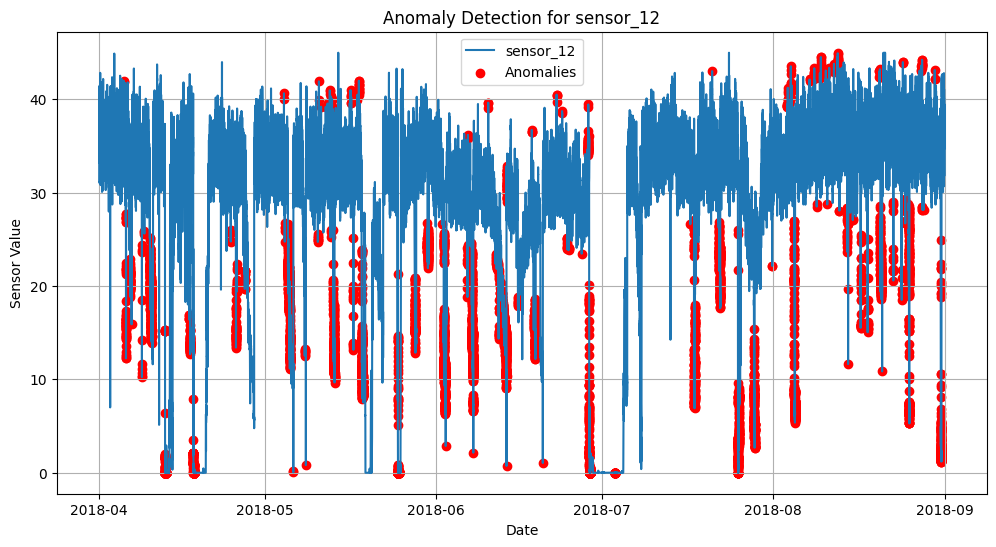

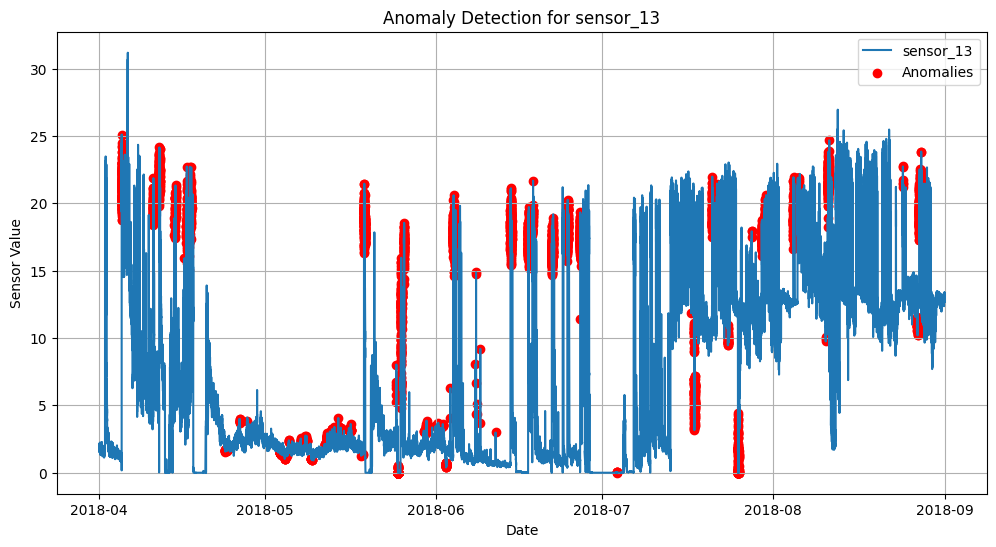

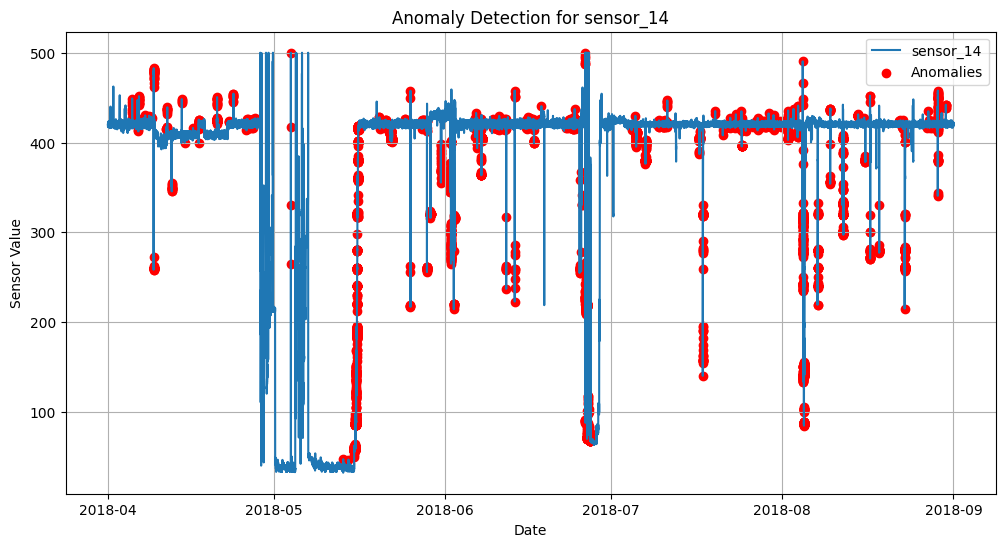

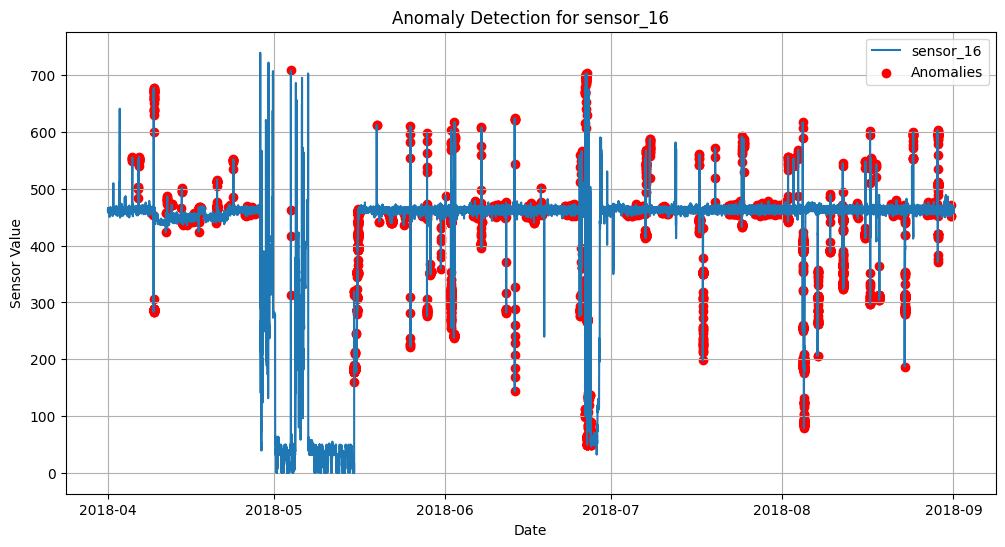

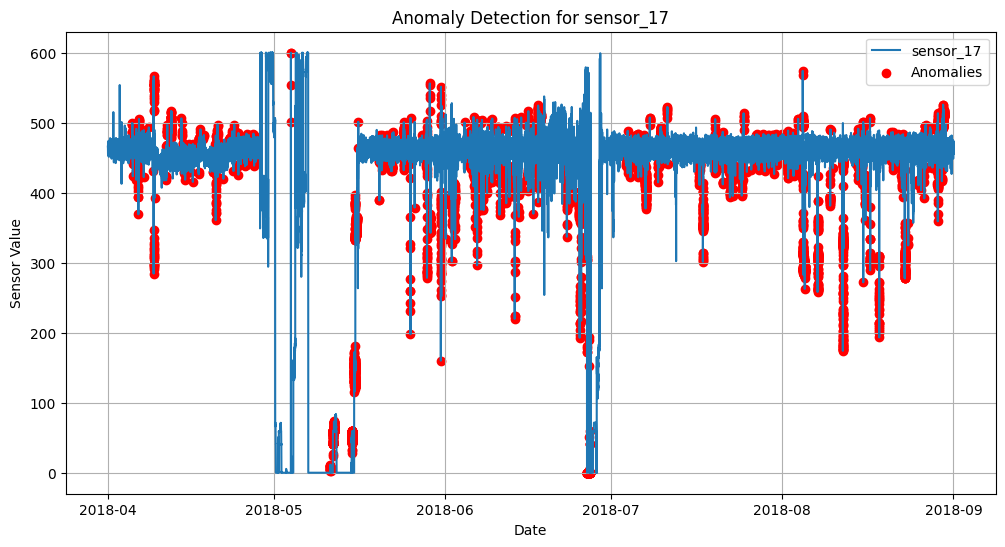

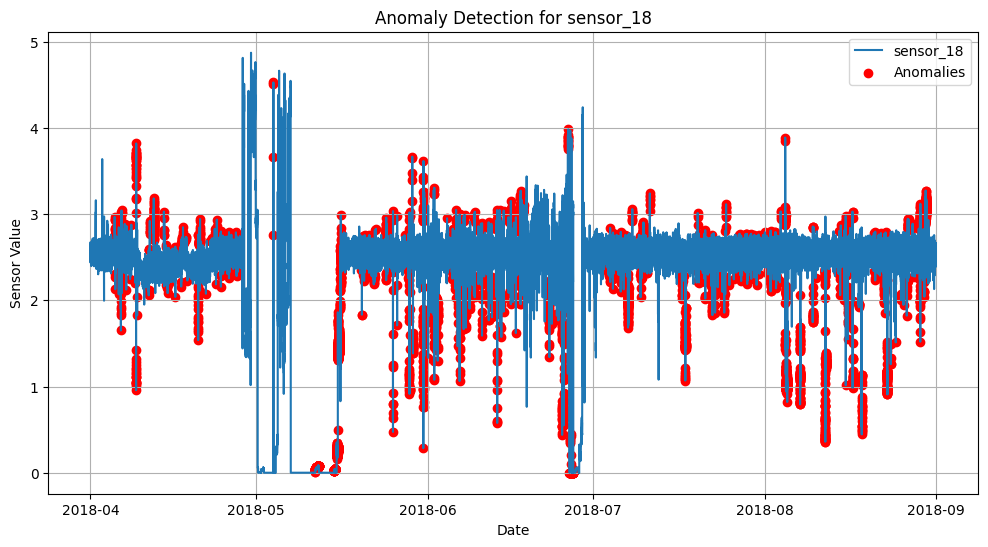

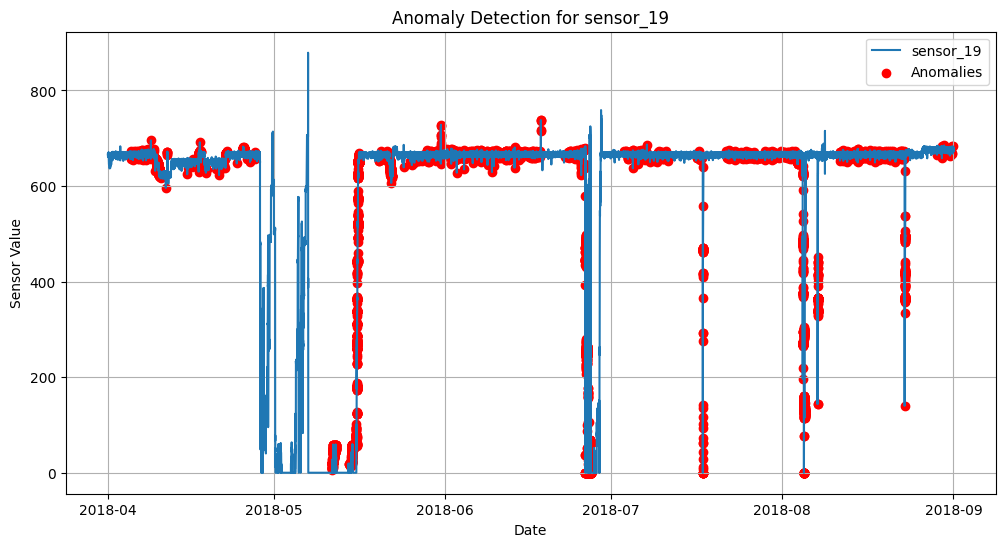

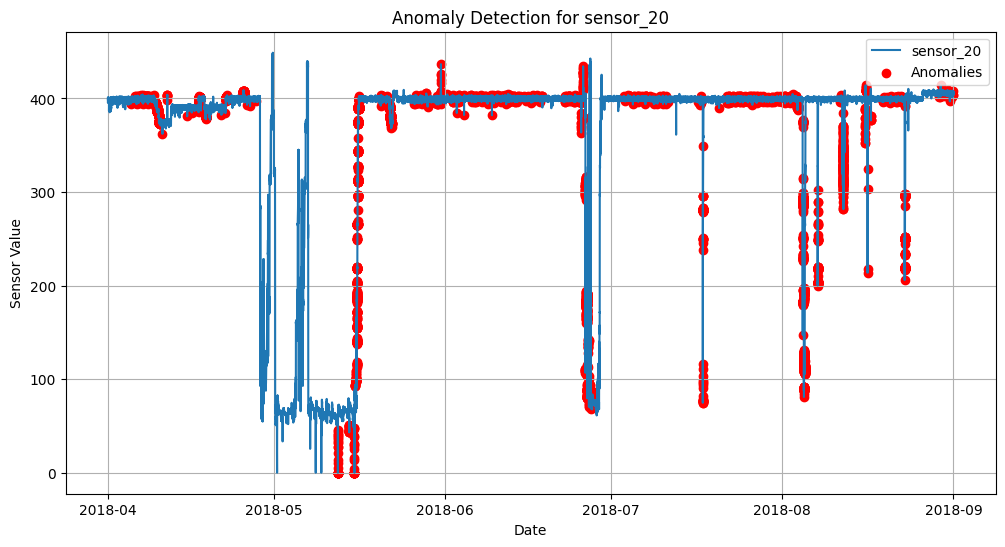

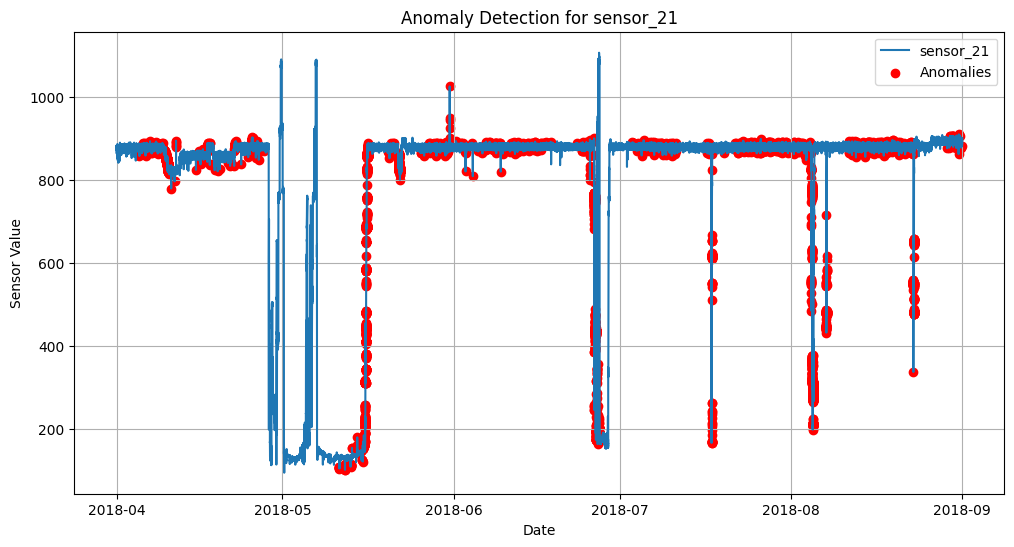

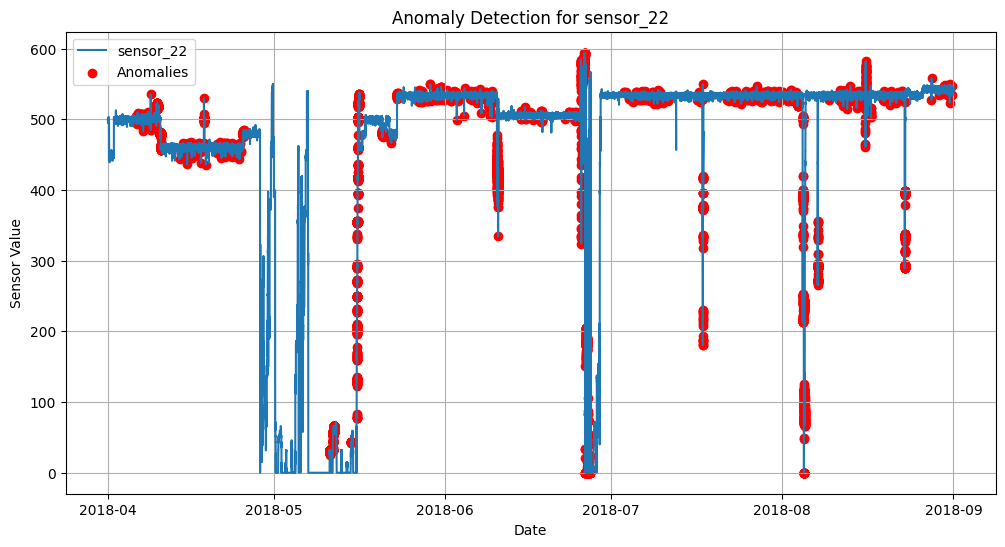

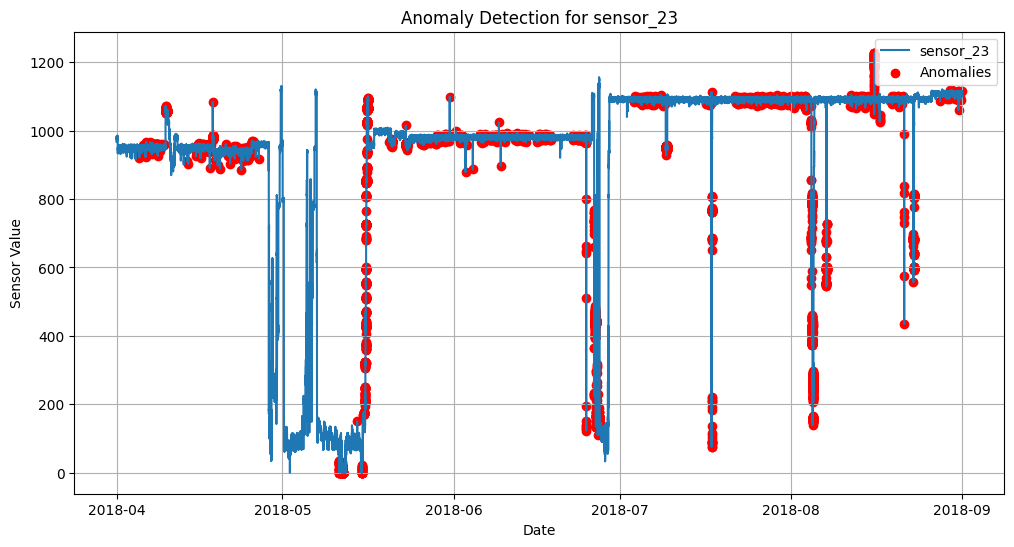

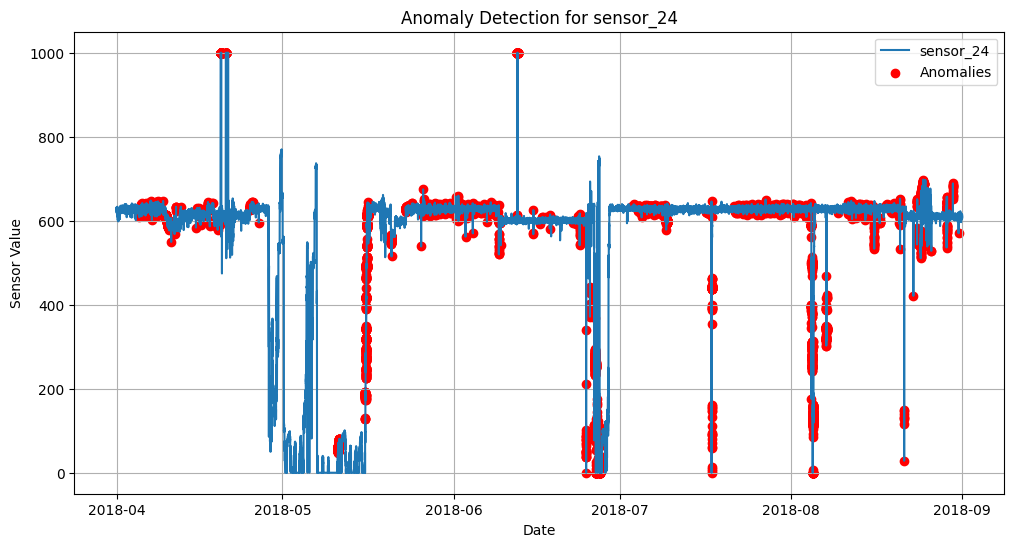

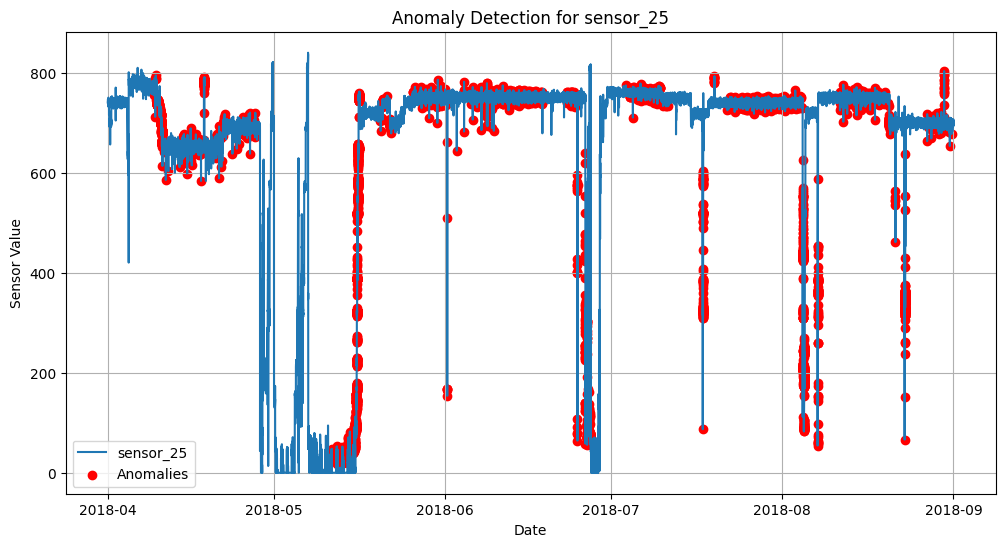

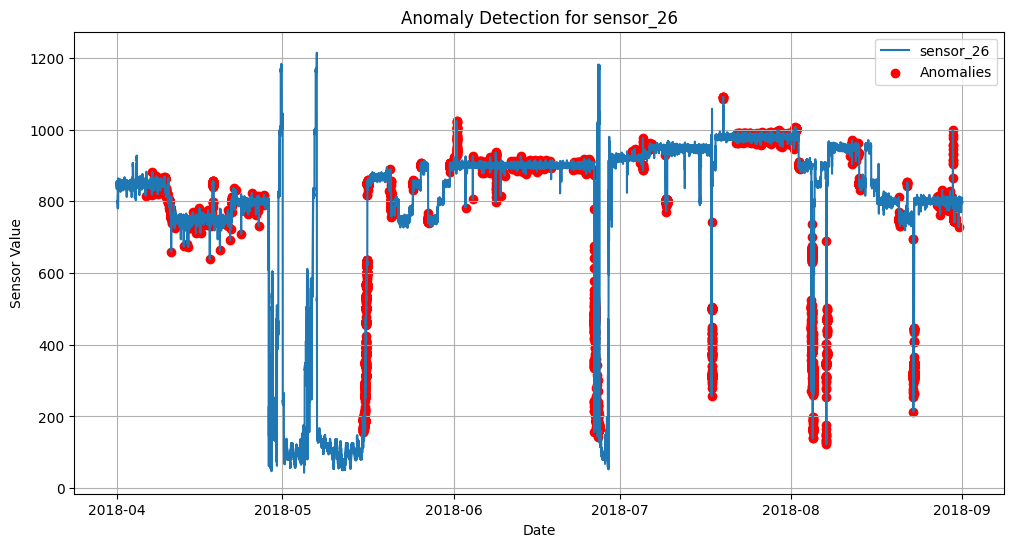

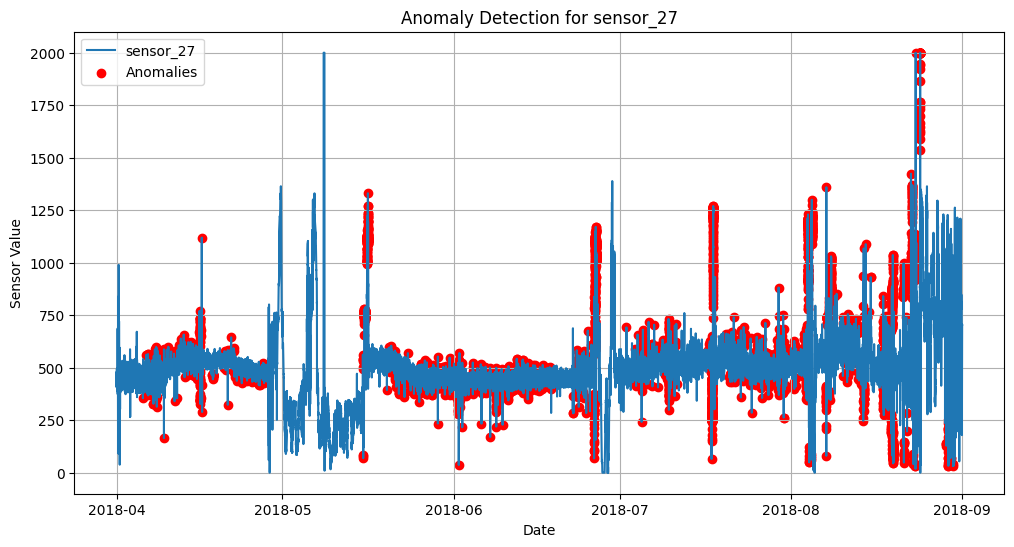

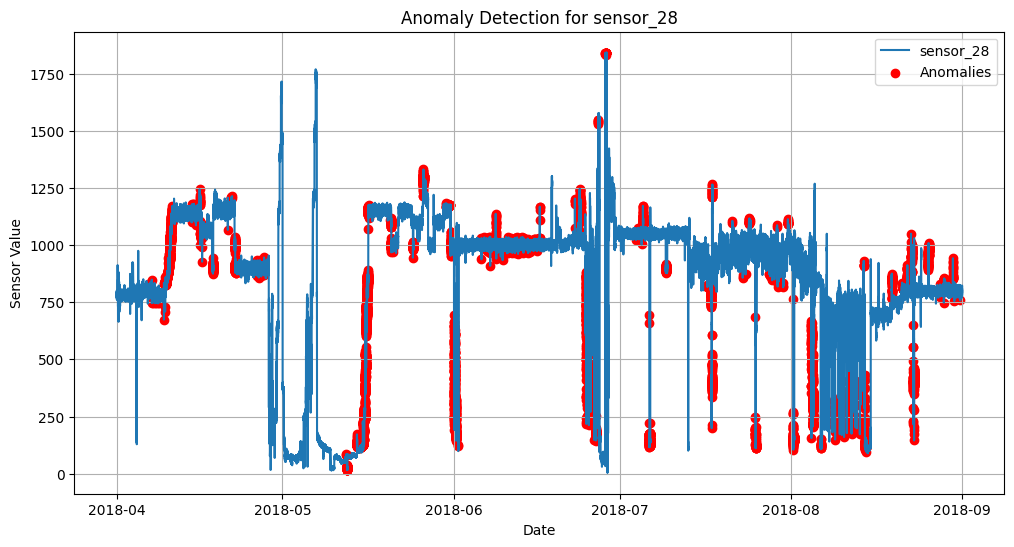

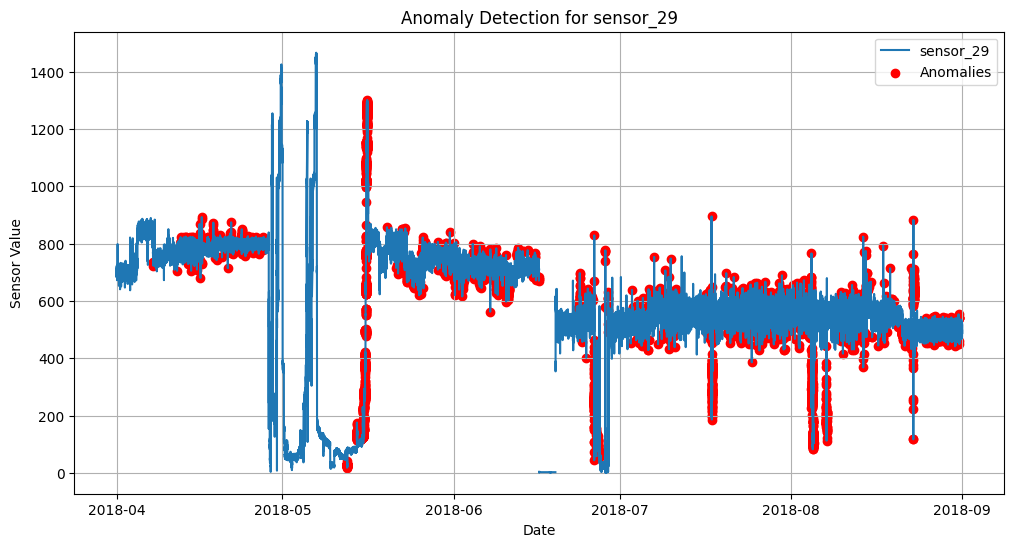

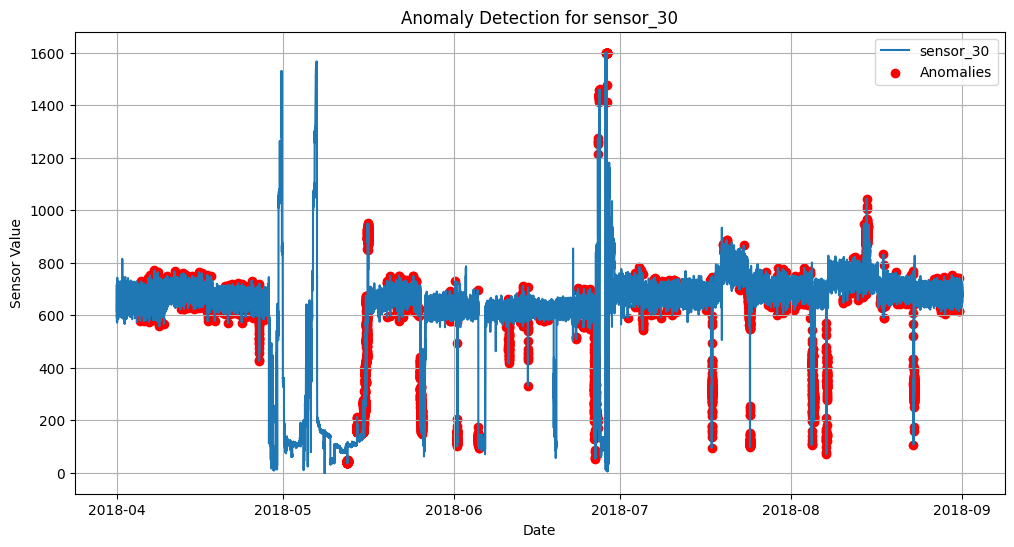

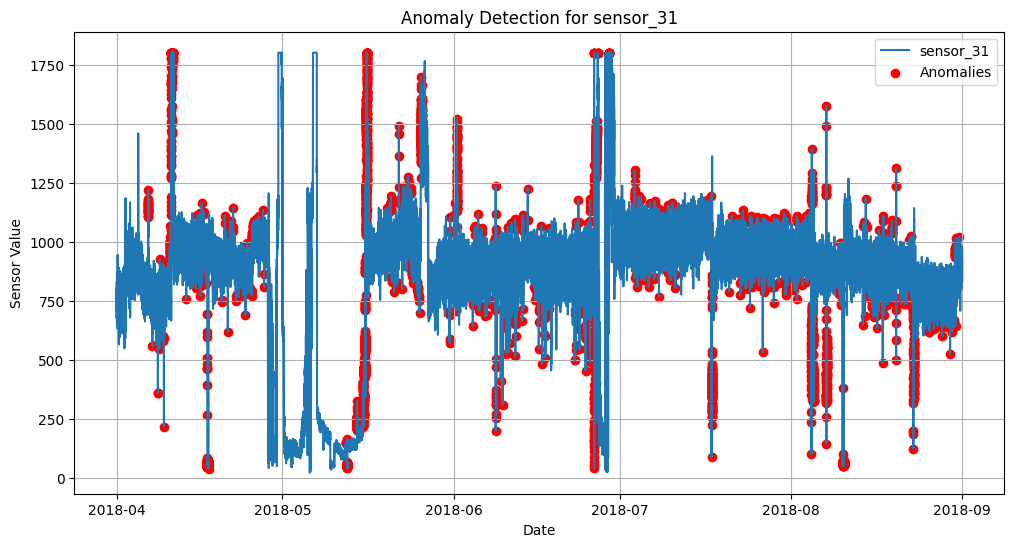

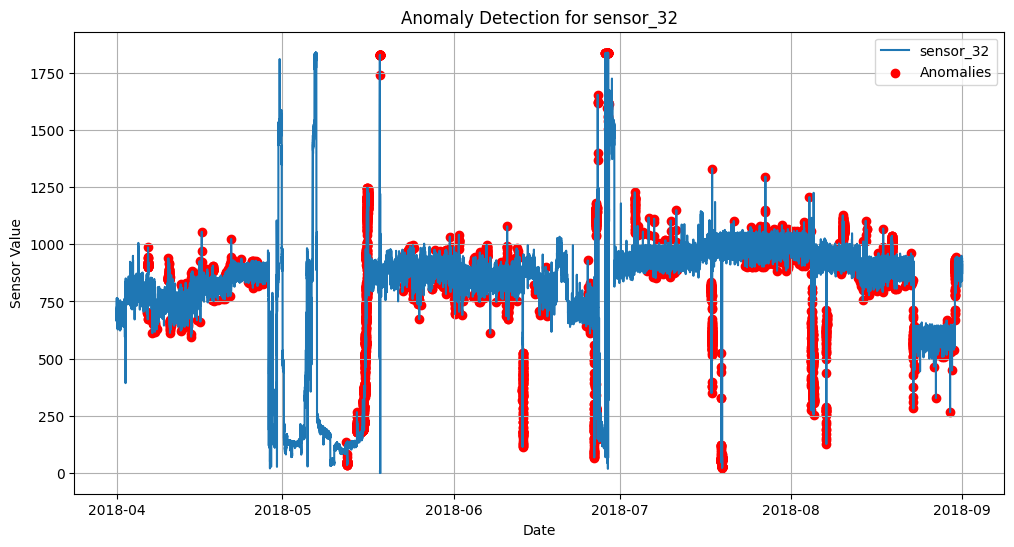

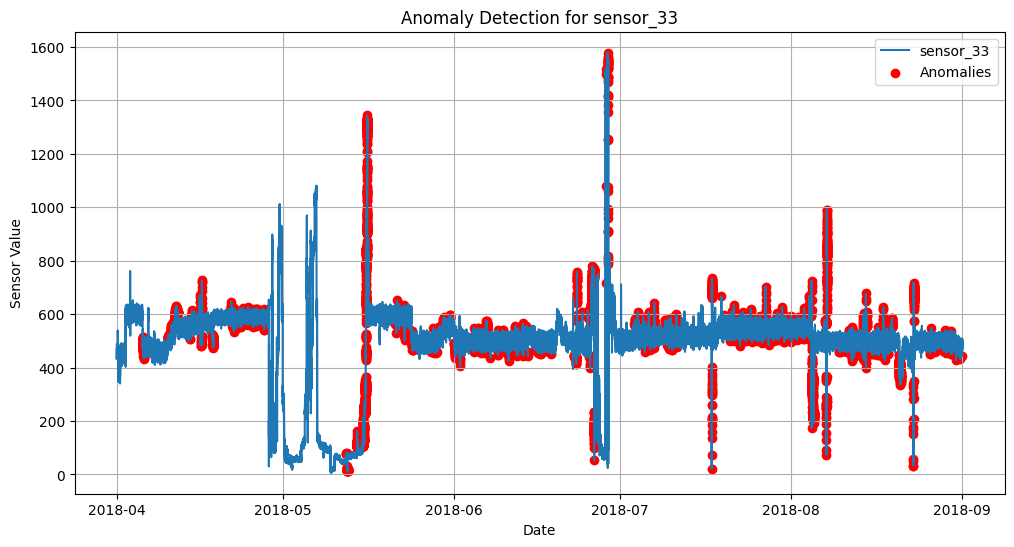

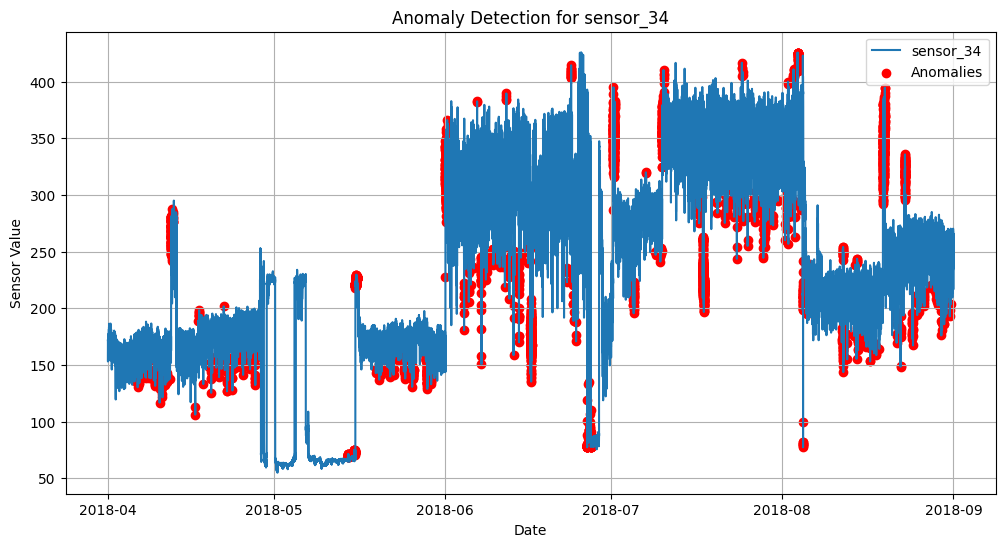

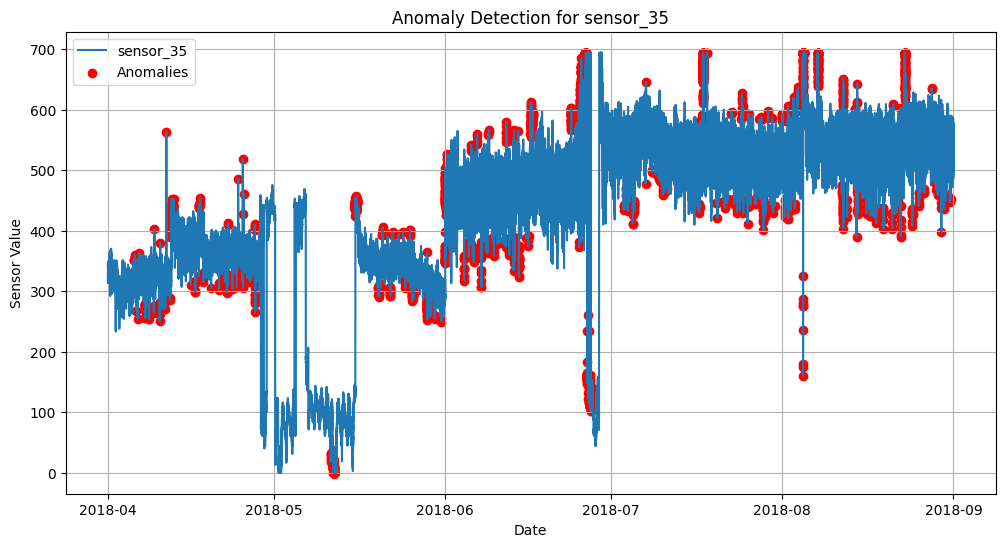

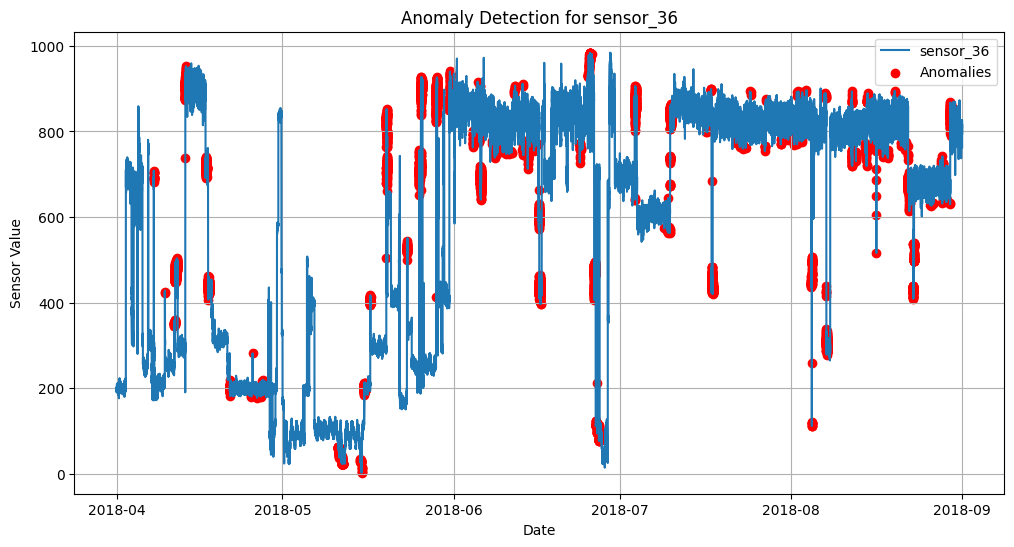

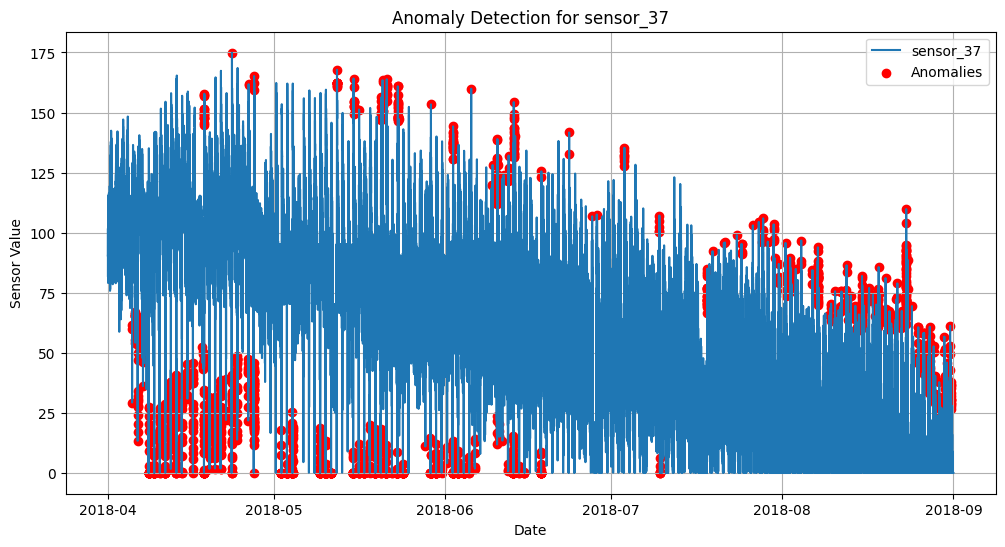

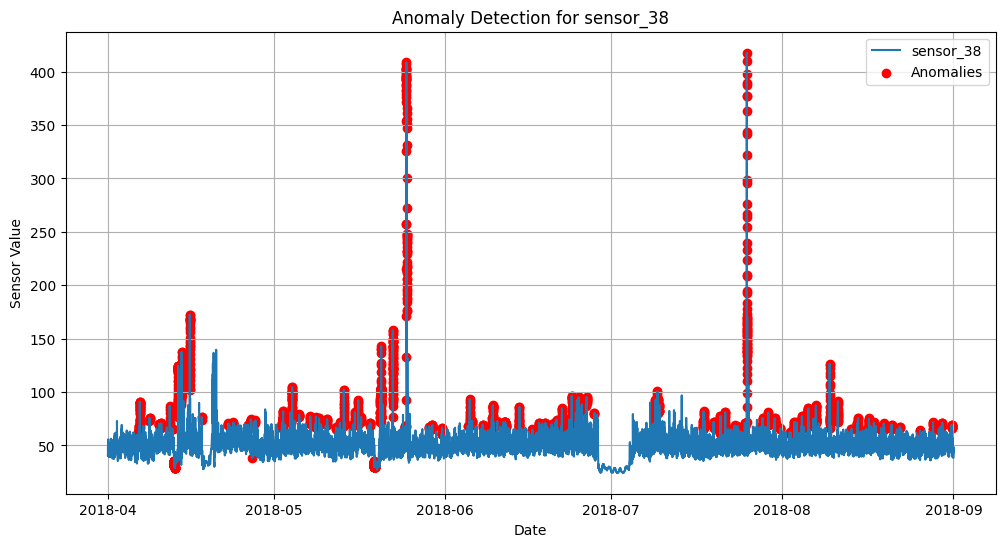

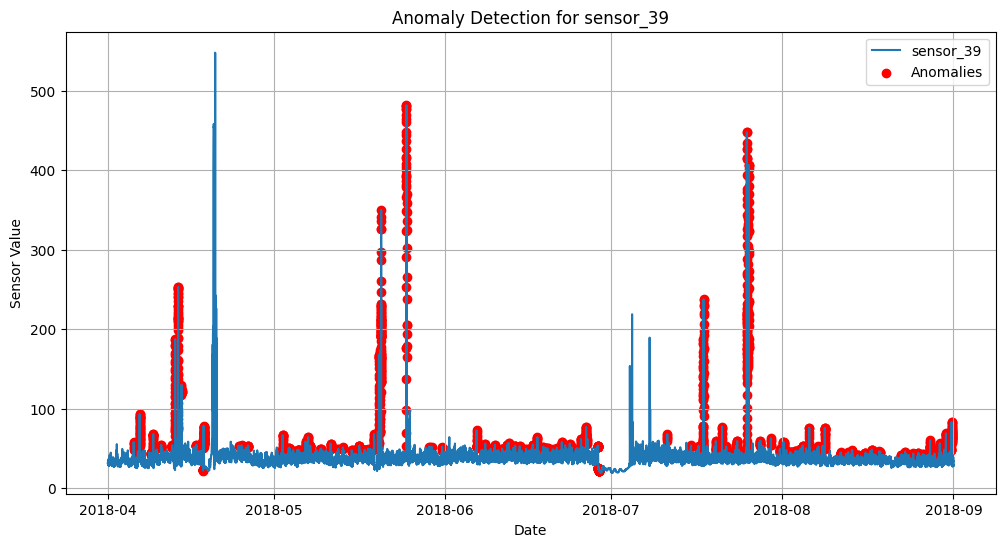

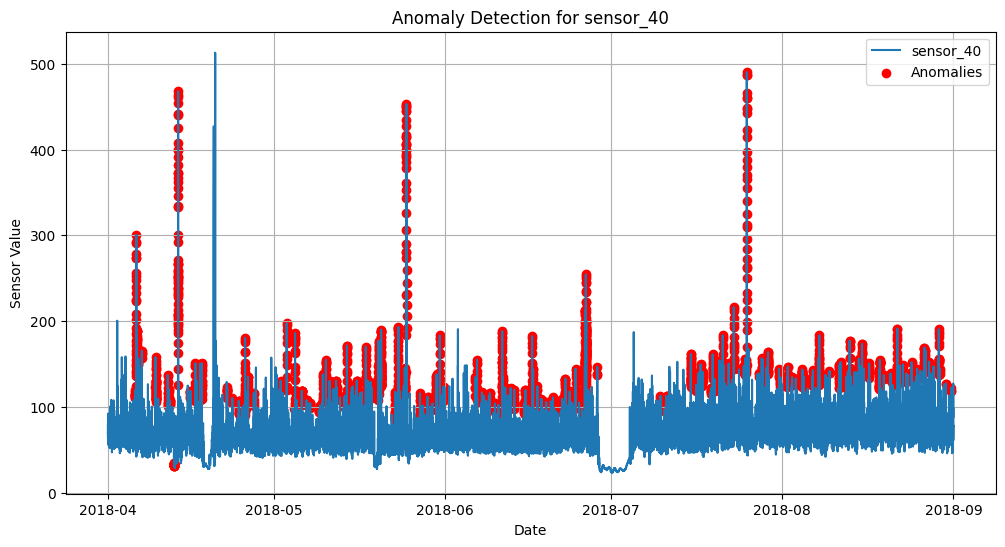

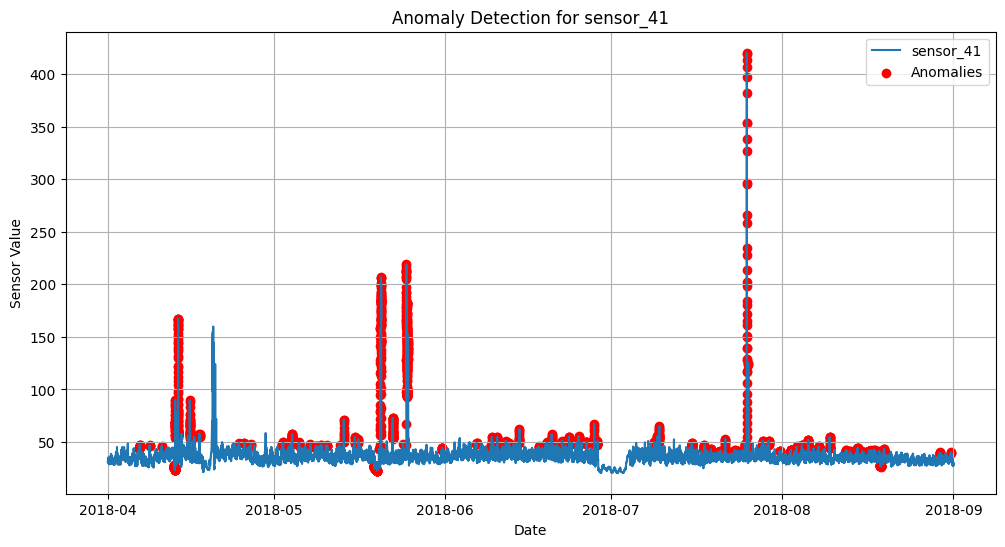

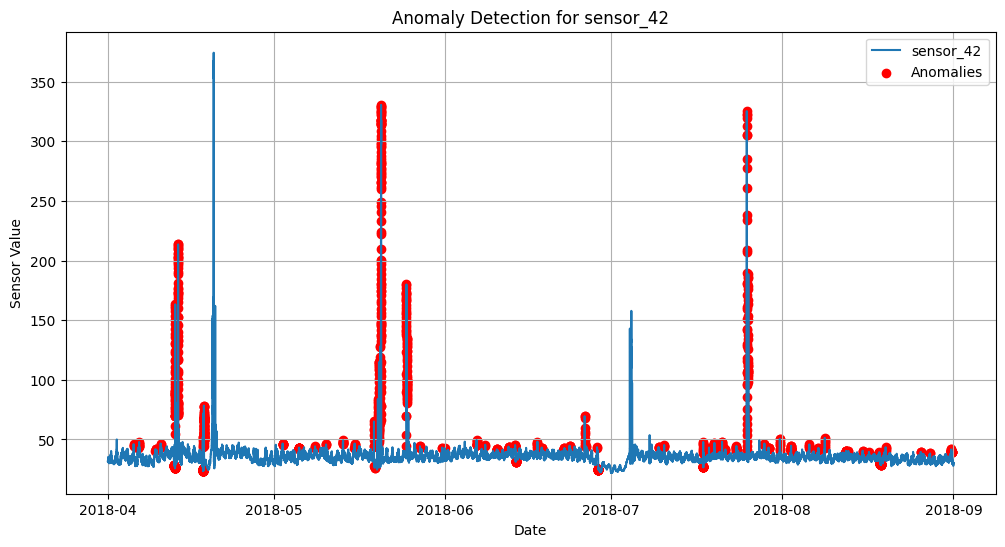

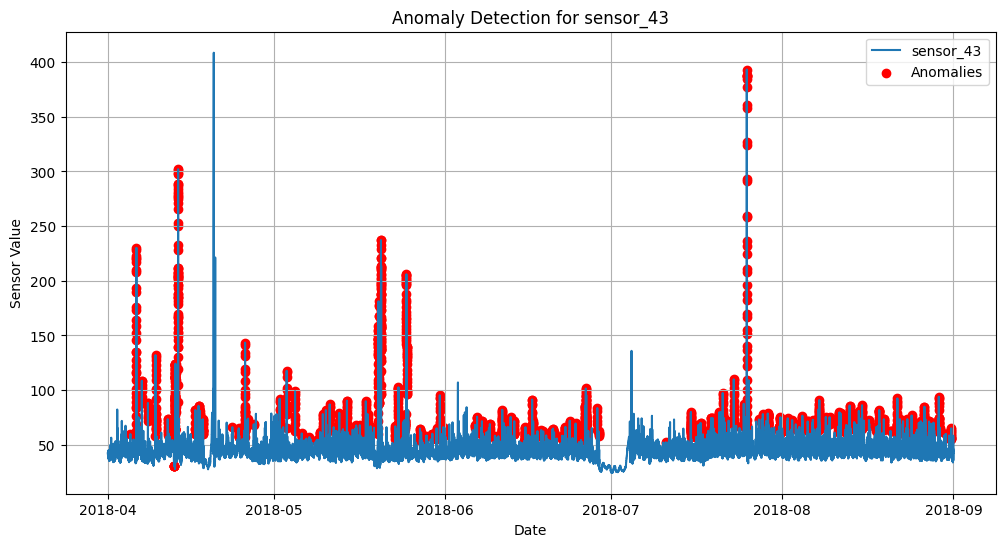

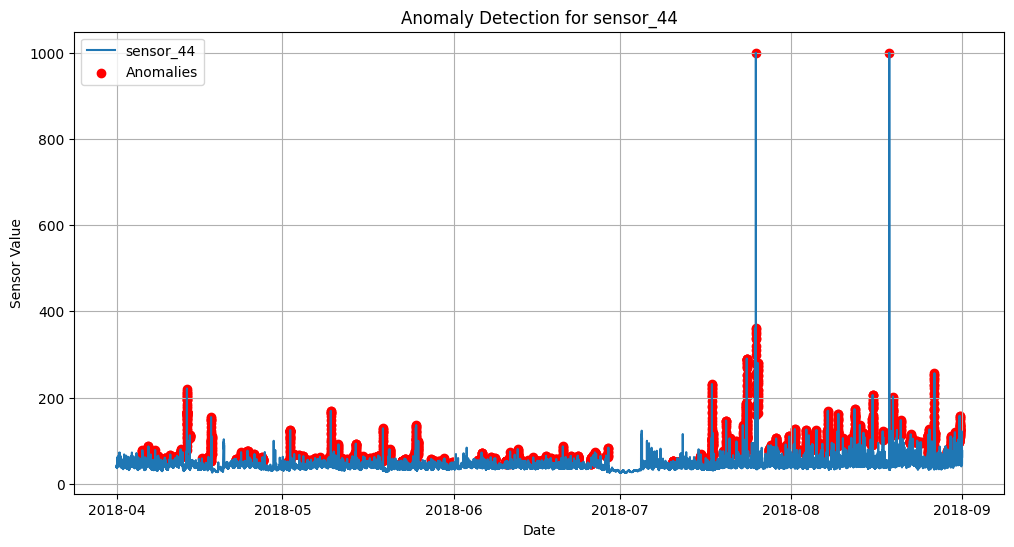

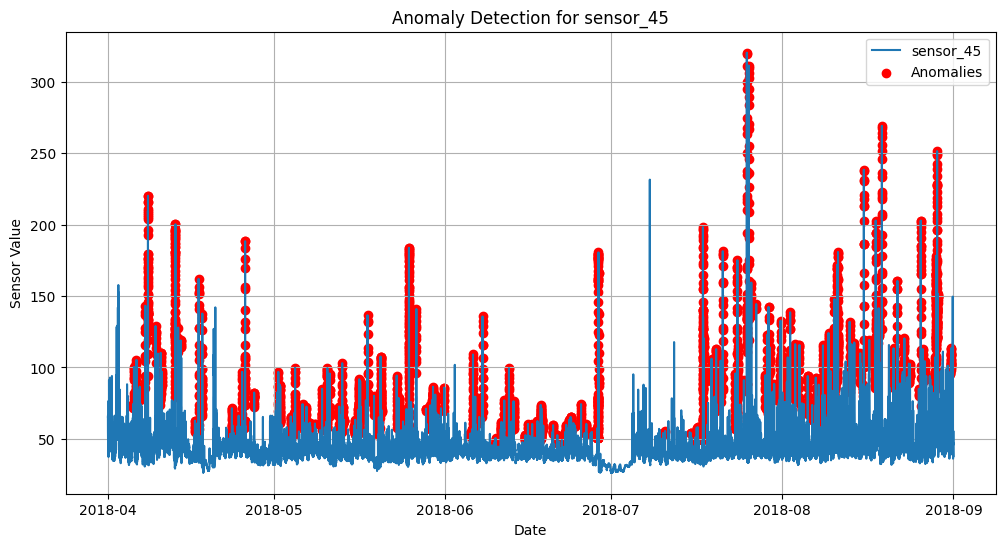

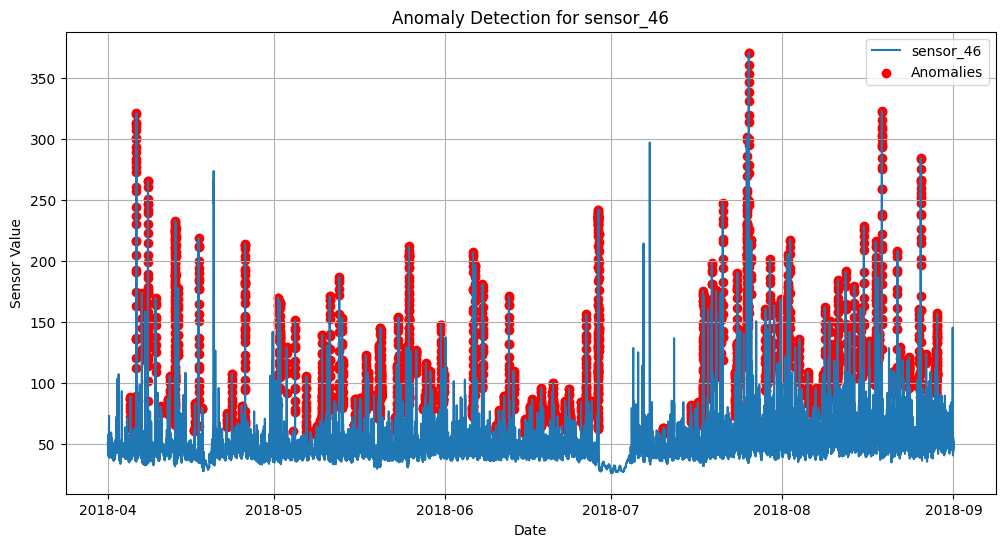

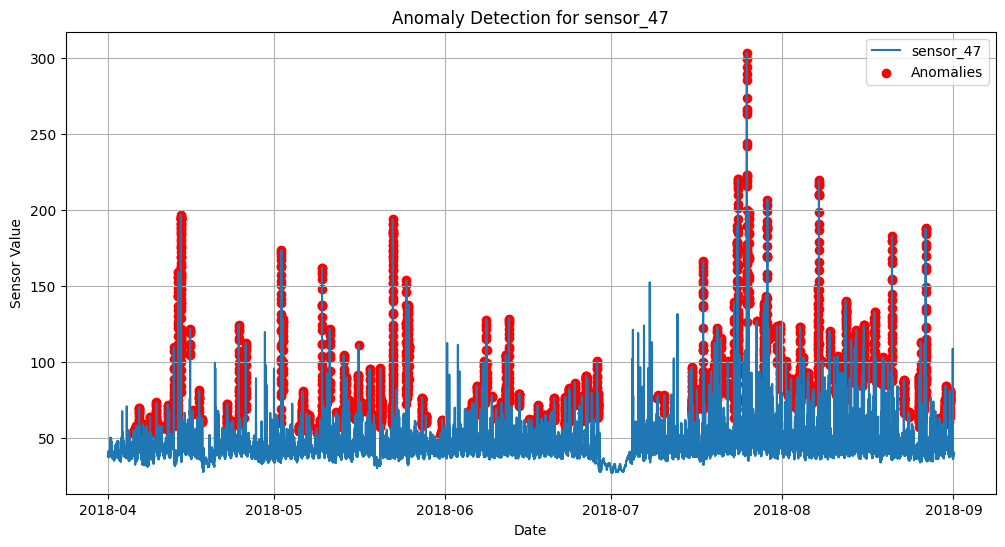

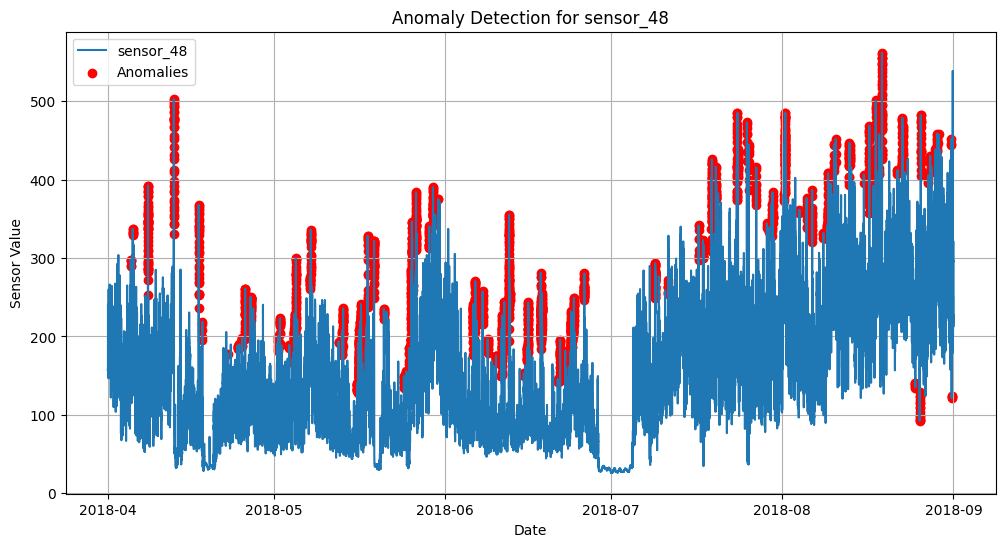

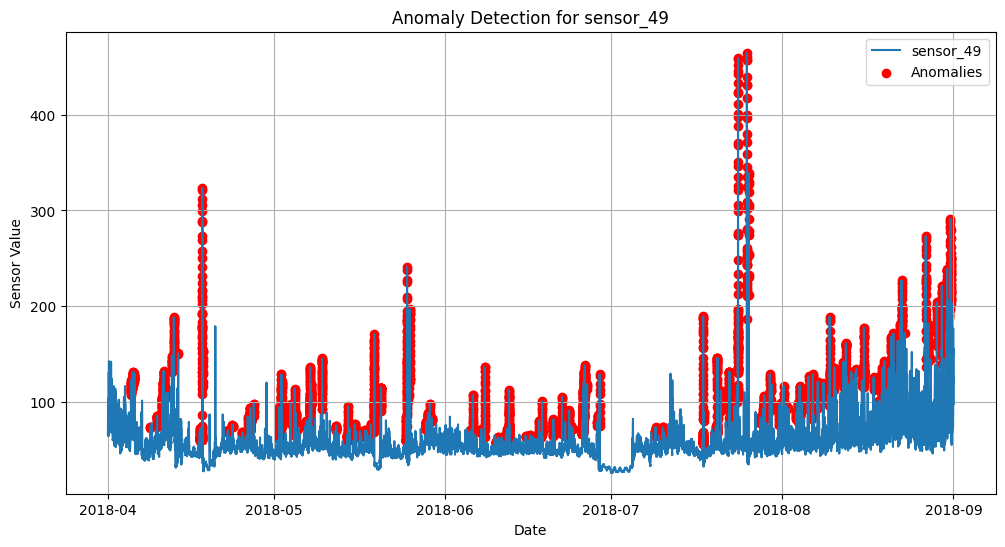

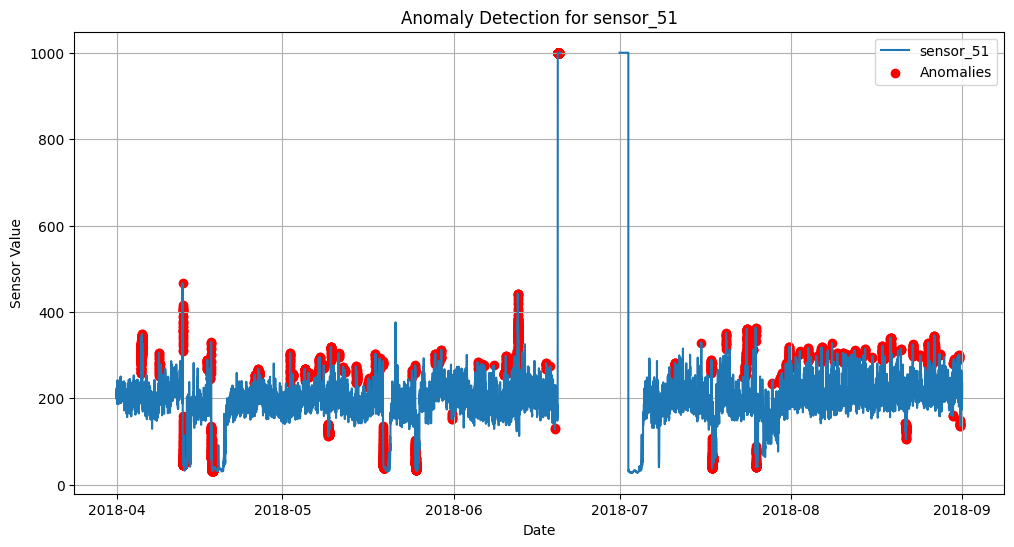

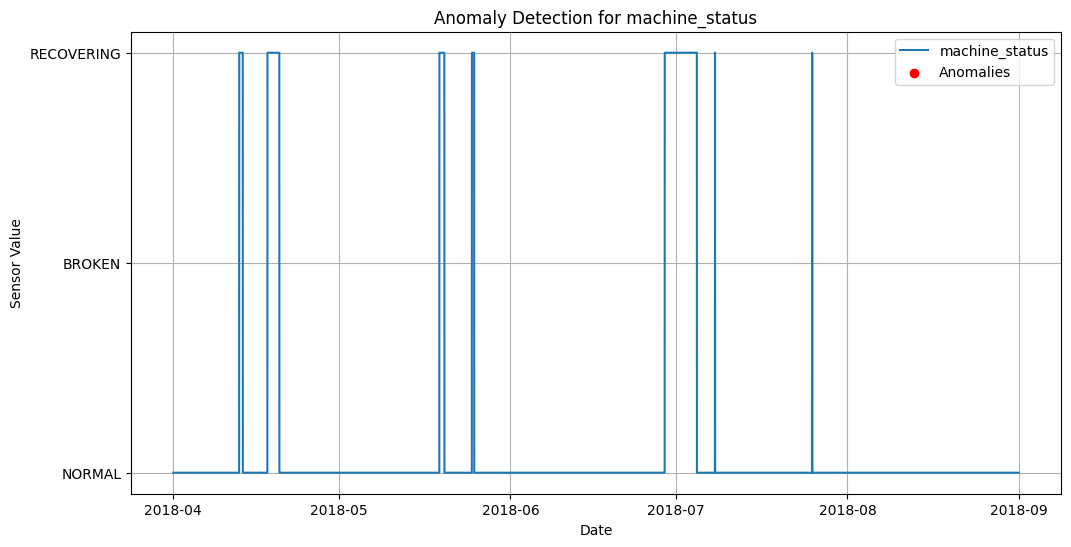

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def detect_anomalies(data, window_size, threshold):
    moving_averages = data.rolling(window_size).mean()
    deviations = data - moving_averages

    anomalies = data[abs(deviations) > threshold]

    return anomalies

def count_outliers(data, window_size, threshold):
    moving_averages = data.rolling(window_size).mean()
    deviations = data - moving_averages

    outliers = abs(deviations) > threshold
    num_outliers = outliers.sum()

    return num_outliers

# Replace 'datetime' with the appropriate index label or column name from your DataFrame
window_size = int(24 * 30.5 * 4)
ma = df.rolling(window_size).mean()

deviation = df - ma
std_deviation = deviation.rolling(window_size).std()
threshold = 3 * std_deviation

anomalies = df[deviation.abs() > threshold]

for column in df.columns:
    if column != 'datetime':
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df[column], label=column)
        plt.scatter(anomalies.index, anomalies[column], color='red', label='Anomalies')
        plt.xlabel('Date')
        plt.ylabel('Sensor Value')
        plt.title(f'Anomaly Detection for {column}')
        plt.legend()
        plt.grid()
        plt.show()

# DBSCAN (Density-based spatial clustering of applications with noise) 

DBSCAN (Density-based spatial clustering of applications with noise) is a density-based clustering algorithm used for unsupervised clustering and outlier detection. It groups data points based on regions of high point density, making it effective for identifying clusters in complex data sets. Unlike k-means, not all points are assigned to a cluster, and the number of clusters does not need to be predetermined. DBSCAN recursively explores points within a specified distance (eps) to form clusters if a minimum number of points (minPts) is met. Outliers, which do not belong to any cluster, are easily identified. Distance plays a crucial role in DBSCAN, and the dataset should be clean and normalized. In Python, sklearn provides an easy-to-use implementation of DBSCAN. The resulting clusters and outliers can be accessed through the fitted model's attributes. https://www.projectpro.io/articleanomaly-detection-using-machine-learning-in-python-with-example/555#mcetoc_1fqgmt45rg.

In [13]:
def detect_anomalies_dbscan(data, eps=0.5, min_samples=5):
    """
    Detect anomalies in a dataset using the dbscan algorithm.
    
    Args:
        data (DataFrame): The input data.
        eps : maximum distance between two samples for one to be considered as in the neighborhood of the other
        min_samples : the number of samples (or total weight) in a neighborhood for a point to be considered as a core point. 
    
    Returns:
        array that contains the time series values identified as anomalies by the DBSCAN algorithm(anomaly_values)
    """
    def detect_anomalies_dbscan(time_series_data, eps=0.5, min_samples=5):
        # Reshape the time series data
        time_series = time_series_data.reshape(-1, 1)

        # Standardize the time series data
        scaler = StandardScaler()
        time_series_scaled = scaler.fit_transform(time_series)

        # Initialize the DBSCAN model
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit the DBSCAN model to the scaled time series data
        dbscan.fit(time_series_scaled)

        # Get the cluster labels for each data point
        cluster_labels = dbscan.labels_

        # Identify anomalies as data points with cluster label -1 (outliers)
        anomaly_indices = np.where(cluster_labels == -1)[0]

        # Get the corresponding time series values for anomalies
        anomaly_values = time_series_data[anomaly_indices]

        return anomaly_indices, anomaly_values

In [19]:
anomaly=detect_anomalies_dbscan(data)
print(anomaly)

None


In [15]:
from sklearn.cluster import DBSCAN
import numpy as np

def detect_anomalies(data, epsilon=0.5, min_samples=5):
    # Create and fit the DBSCAN model
    dbscan = DBSCAN(algorithm='auto', eps=epsilon, min_samples=min_samples)
    dbscan.fit(data)
    
    # Get the predicted labels (clusters) and outliers (-1)
    labels = dbscan.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = list(labels).count(-1)
    
    # Return the number of clusters and outliers detected
    return n_clusters, n_outliers

# Assuming your data is stored in a NumPy array called 'data'
data = data.values

# Call the function to detect anomalies
n_clusters, n_outliers = detect_anomalies(data)

# Print the results
print("Number of clusters: {}".format(n_clusters))
print("Number of outliers: {}".format(n_outliers))

Number of clusters: 2
Number of outliers: 220308
